# Neural Computation Paper Figures

### Imports

In [1]:
import os
os.chdir("../")
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import re
import numpy as np
from skimage import measure
from skimage.io import imread
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import FancyArrowPatch
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.font_manager
import matplotlib.cm as cm
import pickle
import tensorflow as tf
from utils.logger import Logger
from data.dataset import Dataset
import data.data_selector as ds
import analysis.analysis_picker as ap
import utils.data_processing as dp
import utils.plot_functions as pf
import utils.neural_comp_funcs as nc

### Parameters

In [3]:
figsize = (16, 16)
fontsize = 20
dpi = 200

In [4]:
class lca_512_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_512_vh"
    self.display_name = "Sparse Coding 512"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class lca_768_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_vh"
    self.display_name = "Sparse Coding 768"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class lca_1024_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_1024_vh"
    self.display_name = "Sparse Coding 1024"
    self.version = "0.0"
    self.save_info = "analysis_train_carlini_targeted"
    self.overwrite_analysis_log = False

class lca_2560_vh_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_2560_vh"
    self.display_name = "Sparse Coding"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class sae_768_vh_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_vh"
    self.display_name = "Sparse Autoencoder"
    self.version = "1.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class rica_768_vh_params(object):
  def __init__(self):
    self.model_type = "rica"
    self.model_name = "rica_768_vh"
    self.display_name = "Linear Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class ae_768_vh_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_vh"
    self.display_name = "ReLU"
    self.version = "1.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class lca_768_mnist_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_768_mnist"
    self.display_name = "Sparse Coding 768"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class lca_1536_mnist_params(object):
  def __init__(self):
    self.model_type = "lca"
    self.model_name = "lca_1536_mnist"
    self.display_name = "Sparse Coding 1536"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class ae_768_mnist_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_768_mnist"
    self.display_name = "Leaky ReLU"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class sae_768_mnist_params(object):
  def __init__(self):
    self.model_type = "sae"
    self.model_name = "sae_768_mnist"
    self.display_name = "Sparse Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

class rica_768_mnist_params(object):
  def __init__(self):
    self.model_type = "rica"
    self.model_name = "rica_768_mnist"
    self.display_name = "Linear Autoencoder"
    self.version = "0.0"
    self.save_info = "analysis_train_kurakin_targeted"
    self.overwrite_analysis_log = False

class ae_deep_mnist_params(object):
  def __init__(self):
    self.model_type = "ae"
    self.model_name = "ae_deep_mnist"
    self.display_name = "Leaky ReLU"
    self.version = "0.0"
    self.save_info = "analysis_test_carlini_targeted"
    self.overwrite_analysis_log = False

In [5]:
num_levels = 10
color_vals = dict(zip(["lt_green", "md_green", "dk_green", "lt_blue", "md_blue", "dk_blue", "lt_red", "md_red", "dk_red"],
  ["#A9DFBF", "#196F3D", "#27AE60", "#AED6F1", "#3498DB", "#21618C", "#F5B7B1", "#E74C3C", "#943126"]))

### Iso-contour activations comparison

In [6]:
params_list = [rica_768_vh_params(), ae_768_vh_params(), sae_768_vh_params(), lca_2560_vh_params()]
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [7]:
save_name = ""
for analyzer in analyzer_list:
  run_params = np.load(analyzer.analysis_out_dir+"savefiles/iso_params_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"].item()
  min_angle = run_params["min_angle"]
  max_angle = run_params["max_angle"]
  num_neurons = run_params["num_neurons"]
  use_bf_stats = run_params["use_bf_stats"]
  num_comparison_vectors = run_params["num_comparison_vects"]
  x_range = run_params["x_range"]
  y_range = run_params["y_range"]
  num_images = run_params["num_images"]

  iso_vectors = np.load(analyzer.analysis_out_dir+"savefiles/iso_vectors_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.target_neuron_ids = iso_vectors["target_neuron_ids"]
  analyzer.comparison_neuron_ids = iso_vectors["comparison_neuron_ids"]
  analyzer.target_vectors = iso_vectors["target_vectors"]
  analyzer.rand_orth_vectors = iso_vectors["rand_orth_vectors"]
  analyzer.comparison_vectors = iso_vectors["comparison_vectors"]

  analyzer.comp_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.rand_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_activations_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.rand_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_contour_dataset_"+save_name
    +analyzer.analysis_params.save_info+".npz")["data"].item()

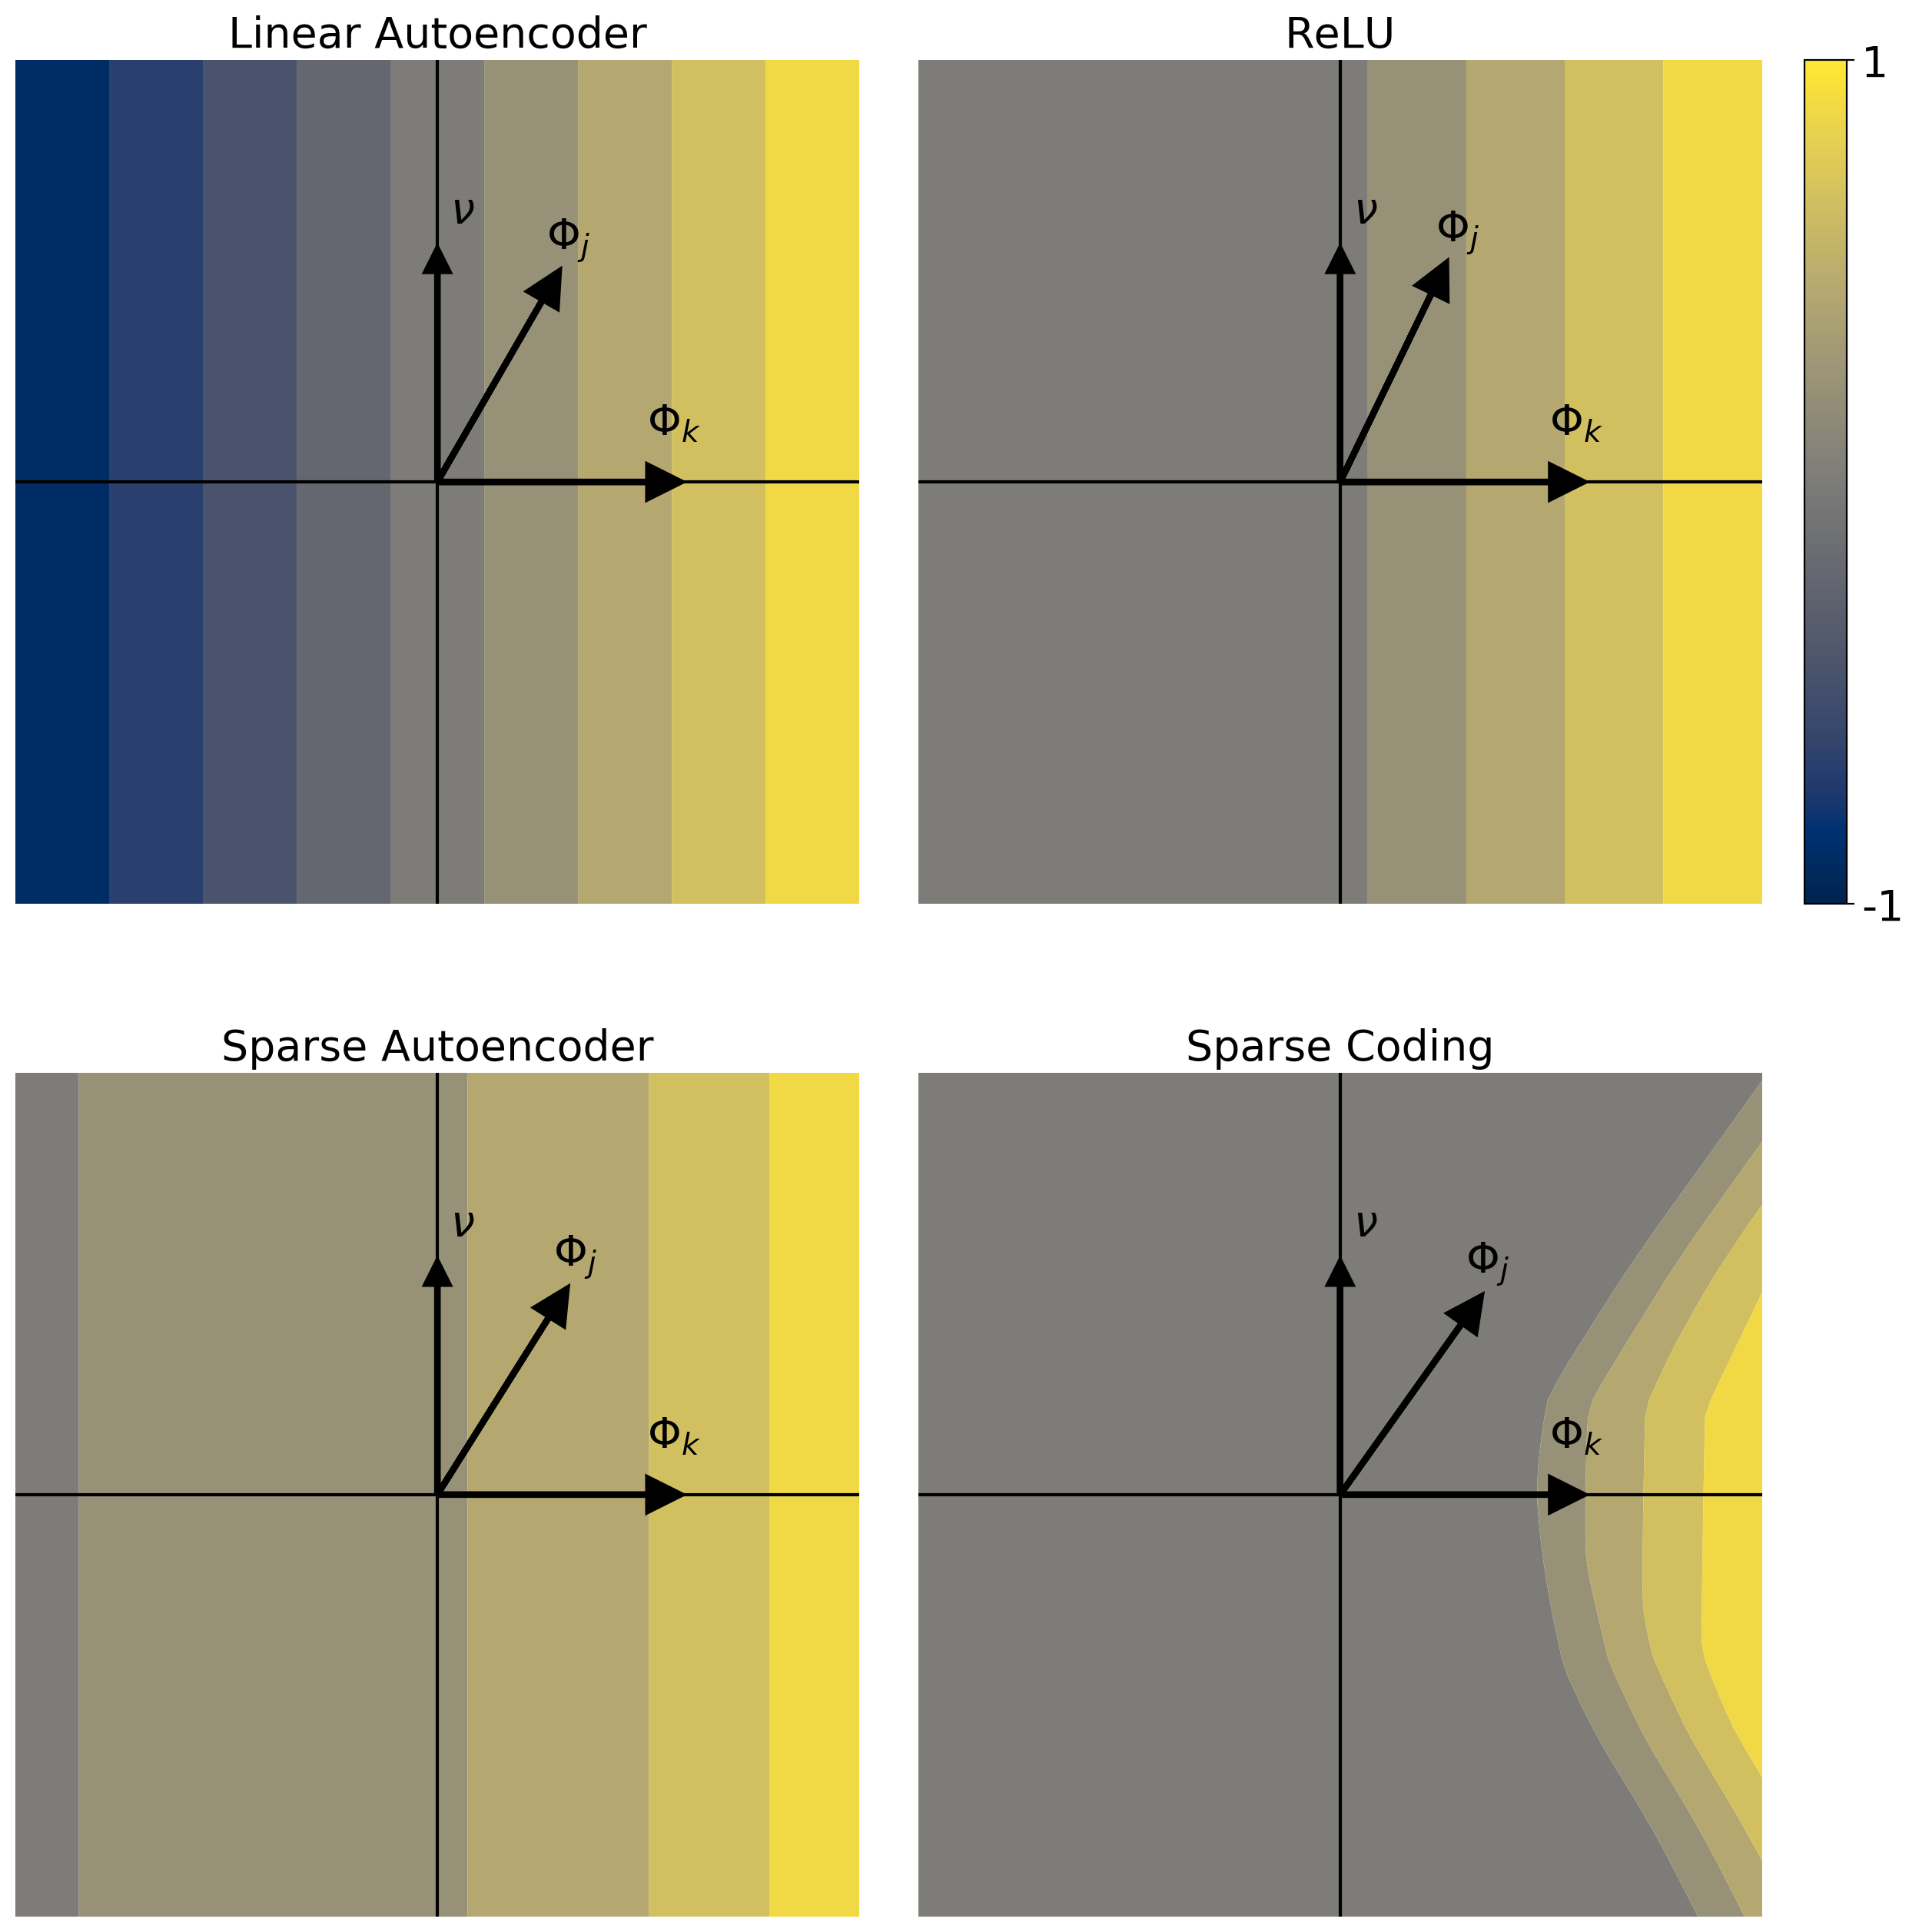

In [8]:
neuron_indices = [0, 0, 0, 0]
orth_indices = [0, 0, 0, 1]
num_plots_y = 2
num_plots_x = 2
show_contours = True

fig, contour_handles = nc.plot_goup_iso_contours(analyzer_list, neuron_indices, orth_indices,
  num_levels, x_range, y_range, show_contours, figsize, dpi, fontsize)
for analyzer, neuron_index, orth_index in zip(analyzer_list, neuron_indices, orth_indices):
  for ext in [".png", ".eps"]:
    neuron_str = str(analyzer.target_neuron_ids[neuron_index])
    orth_str = str(analyzer.comparison_neuron_ids[neuron_index][orth_index])
    save_name = analyzer.analysis_out_dir+"/vis/iso_contour_comparison_"
    if not show_contours:
      save_name += "continuous_"
    save_name += "bf0id"+neuron_str+"_bf1id"+orth_str+"_"+analyzer.analysis_params.save_info+ext
    fig.savefig(save_name, dpi=dpi, transparent=True, bbox_inches="tight", pad_inches=0.01)

### Curvature histogram

In [9]:
params_list = [lca_512_vh_params(), lca_768_vh_params(), lca_2560_vh_params()]
iso_save_name = "iso_curvature_xrange1.3_yrange-2.2_"
attn_save_name = "1d_"

for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)

analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

  iso_run_params = np.load(analyzer.analysis_out_dir+"savefiles/iso_params_"+iso_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.iso_comp_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_"+iso_save_name+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.iso_comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_"+iso_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.iso_rand_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_activations_"+iso_save_name+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.iso_rand_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_contour_dataset_"+iso_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()

  analyzer.iso_num_target_neurons = iso_run_params["num_neurons"]
  analyzer.iso_num_comparison_vectors = iso_run_params["num_comparison_vects"]
  
  attn_run_params = np.load(analyzer.analysis_out_dir+"savefiles/iso_params_"+attn_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.attn_comp_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_"+attn_save_name+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.attn_comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_"+attn_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()
  analyzer.attn_rand_activations = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_activations_"+attn_save_name+analyzer.analysis_params.save_info+".npz")["data"]
  analyzer.attn_rand_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_rand_contour_dataset_"+attn_save_name+analyzer.analysis_params.save_info+".npz")["data"].item()
  
  analyzer.attn_num_target_neurons = attn_run_params["num_neurons"]
  analyzer.attn_num_comparison_vectors = attn_run_params["num_comparison_vects"]
  
mesh_save_name = "iso_curvature_ryan_"
contour_activity = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_activations_"+mesh_save_name
  +analyzer.analysis_params.save_info+".npz")["data"][0, 1, ...]
comp_contour_dataset = np.load(analyzer.analysis_out_dir+"savefiles/iso_comp_contour_dataset_"+mesh_save_name
  +analyzer.analysis_params.save_info+".npz")["data"].item()
x = range(comp_contour_dataset["x_pts"].size)
y = range(comp_contour_dataset["y_pts"].size)
contour_pts = (x,y)

In [10]:
target_act = 0.3 # target activity spot between min & max value of normalized activity (btwn 0 and 1)
for analyzer in analyzer_list:
  analyzer.iso_comp_curvatures = []
  analyzer.iso_rand_curvatures = []
  activations_and_curvatures = ((analyzer.iso_comp_activations, analyzer.iso_comp_curvatures),
    (analyzer.iso_rand_activations, analyzer.iso_rand_curvatures))
  for activations, curvatures in activations_and_curvatures:
    (num_neurons, num_planes, num_points_y, num_points_x) = activations.shape
    for neuron_id in range(num_neurons):
      sub_curvatures = []
      for plane_id in range(num_planes):
        activity = activations[neuron_id, plane_id, ...]
        ## mirror top half of activations to bottom half to only measure curvature in the upper quadrant
        num_y, num_x = activity.shape 
        activity[:int(num_y/2), :] = activity[int(num_y/2):, :][::-1,:]
        ## compute curvature
        contours = measure.find_contours(activity, target_act)[0]
        x_vals = contours[:,1]
        y_vals = contours[:,0]
        coeffs = np.polynomial.polynomial.polyfit(y_vals, x_vals, deg=2)
        sub_curvatures.append(coeffs[-1])
      curvatures.append(sub_curvatures)

  comp_x_pts = analyzer.attn_comp_contour_dataset["x_pts"]
  rand_x_pts = analyzer.attn_rand_contour_dataset["x_pts"]
  assert(np.all(comp_x_pts == rand_x_pts)) # This makes sure we don't need to recompute proj_datapoints for each case
  num_x_imgs = len(comp_x_pts)
  x_target = comp_x_pts[num_x_imgs-1] # find a location to take a slice
  proj_datapoints = analyzer.attn_comp_contour_dataset["proj_datapoints"]
  slice_indices = np.where(proj_datapoints[:, 0] == x_target)[0]
  analyzer.sliced_datapoints = proj_datapoints[slice_indices, :][:, :] # slice grid

  analyzer.attn_comp_curvatures = []
  analyzer.attn_comp_fits = []
  analyzer.attn_comp_sliced_activity = []
  analyzer.attn_rand_curvatures = []
  analyzer.attn_rand_fits = []
  analyzer.attn_rand_sliced_activity = []
  for neuron_index in range(analyzer.attn_num_target_neurons):
    sub_comp_curvatures = []
    sub_comp_fits = []
    sub_comp_sliced_activity = []
    sub_comp_delta_activity = []
    sub_rand_curvatures = []
    sub_rand_fits = []
    sub_rand_sliced_activity = []
    for orth_index in range(analyzer.attn_num_comparison_vectors):
      comp_activity = analyzer.attn_comp_activations[neuron_index, orth_index, ...].reshape([-1])
      sub_comp_sliced_activity.append(comp_activity[slice_indices][:])
      coeff = np.polynomial.polynomial.polyfit(analyzer.sliced_datapoints[:, 1],
        sub_comp_sliced_activity[-1], deg=2) # [c0, c1, c2], where p = c0 + c1x + c2x^2
      sub_comp_curvatures.append(coeff[2])
      sub_comp_fits.append(np.polynomial.polynomial.polyval(analyzer.sliced_datapoints[:, 1], coeff))
      
    num_rand_vectors = np.minimum(analyzer.bf_stats["num_inputs"]-1, analyzer.attn_num_comparison_vectors)
    for orth_index in range(num_rand_vectors):
      rand_activity = analyzer.attn_rand_activations[neuron_index, orth_index, ...].reshape([-1])
      sub_rand_sliced_activity.append(rand_activity[slice_indices][:])
      coeff = np.polynomial.polynomial.polyfit(analyzer.sliced_datapoints[:, 1],
        sub_rand_sliced_activity[-1], deg=2)
      sub_rand_curvatures.append(coeff[2])
      sub_rand_fits.append(np.polynomial.polynomial.polyval(analyzer.sliced_datapoints[:, 1], coeff))

    analyzer.attn_comp_curvatures.append(sub_comp_curvatures)
    analyzer.attn_comp_fits.append(sub_comp_fits)
    analyzer.attn_comp_sliced_activity.append(sub_comp_sliced_activity)
    analyzer.attn_rand_curvatures.append(sub_rand_curvatures)
    analyzer.attn_rand_fits.append(sub_rand_fits)
    analyzer.attn_rand_sliced_activity.append(sub_rand_sliced_activity)

In [11]:
num_bins = 50
def get_bins(all_curvatures, num_bins=50):
  max_curvature = np.amax(all_curvatures)
  min_curvature = np.amin(all_curvatures)
  bin_width = (max_curvature - min_curvature) / (num_bins-1) # subtract 1 to leave room for the zero bin
  bin_centers = [0.0]
  while min(bin_centers) > min_curvature:
    bin_centers.append(bin_centers[-1]-bin_width)
  bin_centers = bin_centers[::-1]
  while max(bin_centers) < max_curvature:
    bin_centers.append(bin_centers[-1]+bin_width)
  bin_lefts = bin_centers - (bin_width / 2)
  bin_rights = bin_centers + (bin_width / 2)
  bins = np.append(bin_lefts, bin_rights[-1])
  return bins

iso_all_curvatures = []
for analyzer in analyzer_list:
  for neuron_index in range(num_neurons):
    iso_all_curvatures += analyzer.iso_comp_curvatures[neuron_index]
    iso_all_curvatures += analyzer.iso_rand_curvatures[neuron_index]
iso_bins = get_bins(iso_all_curvatures, num_bins)

attn_all_curvatures = []
for analyzer in analyzer_list:
  for neuron_index in range(analyzer.attn_num_target_neurons):
    attn_all_curvatures += analyzer.attn_comp_curvatures[neuron_index]
    attn_all_curvatures += analyzer.attn_rand_curvatures[neuron_index]
attn_bins = get_bins(attn_all_curvatures, num_bins)
  
for analyzer in analyzer_list:
  flat_comp_curvatures = [item for sub_list in analyzer.iso_comp_curvatures for item in sub_list]
  comp_hist, analyzer.iso_bin_edges = np.histogram(flat_comp_curvatures, iso_bins, density=False)
  analyzer.iso_comp_hist = comp_hist / np.sum(comp_hist)
  flat_rand_curvatures = [item for sub_list in analyzer.iso_rand_curvatures for item in sub_list]
  rand_hist, _ = np.histogram(flat_rand_curvatures, iso_bins, density=False)
  analyzer.iso_rand_hist = rand_hist / np.sum(rand_hist)

  flat_comp_curvatures = [item for sub_list in analyzer.attn_comp_curvatures for item in sub_list]
  comp_hist, analyzer.attn_bin_edges = np.histogram(flat_comp_curvatures, attn_bins, density=False)
  analyzer.attn_comp_hist = comp_hist / np.sum(comp_hist)
  flat_rand_curvatures = [item for sub_list in analyzer.attn_rand_curvatures for item in sub_list]
  rand_hist, _ = np.histogram(flat_rand_curvatures, attn_bins, density=False)
  analyzer.attn_rand_hist = rand_hist / np.sum(rand_hist)

In [12]:
iso_hist_list = [[analyzer.iso_comp_hist for analyzer in analyzer_list],
  [analyzer.iso_rand_hist for analyzer in analyzer_list]]
label_list = [["Comparison vectors, 2x", "Comparison vectors, 4x", "Comparison vectors, 10x"],
  ["Random vectors, 2x", "Random vectors, 4x", "Random vectors, 10x"]]
color_list = [[color_vals["lt_red"], color_vals["md_red"], color_vals["dk_red"]],
  [color_vals["lt_blue"], color_vals["md_blue"], color_vals["dk_blue"]]]

plot_bin_lefts, plot_bin_rights = analyzer_list[0].iso_bin_edges[:-1], analyzer_list[0].iso_bin_edges[1:]
iso_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_loc = [0.5, 0.3]
iso_title = "Iso-Response"
iso_xlabel = "Curvature of Iso-Response Contours"

attn_hist_list = [[analyzer.attn_comp_hist for analyzer in analyzer_list],
  [analyzer.attn_rand_hist for analyzer in analyzer_list]]

plot_bin_lefts, plot_bin_rights = analyzer_list[0].attn_bin_edges[:-1], analyzer_list[0].attn_bin_edges[1:]
attn_plot_bin_centers = plot_bin_lefts + (plot_bin_rights - plot_bin_lefts)

label_loc = [0.08, 0.30]
attn_title = "Response Attenuation"
attn_xlabel = "Curvature of Response Attenuation"

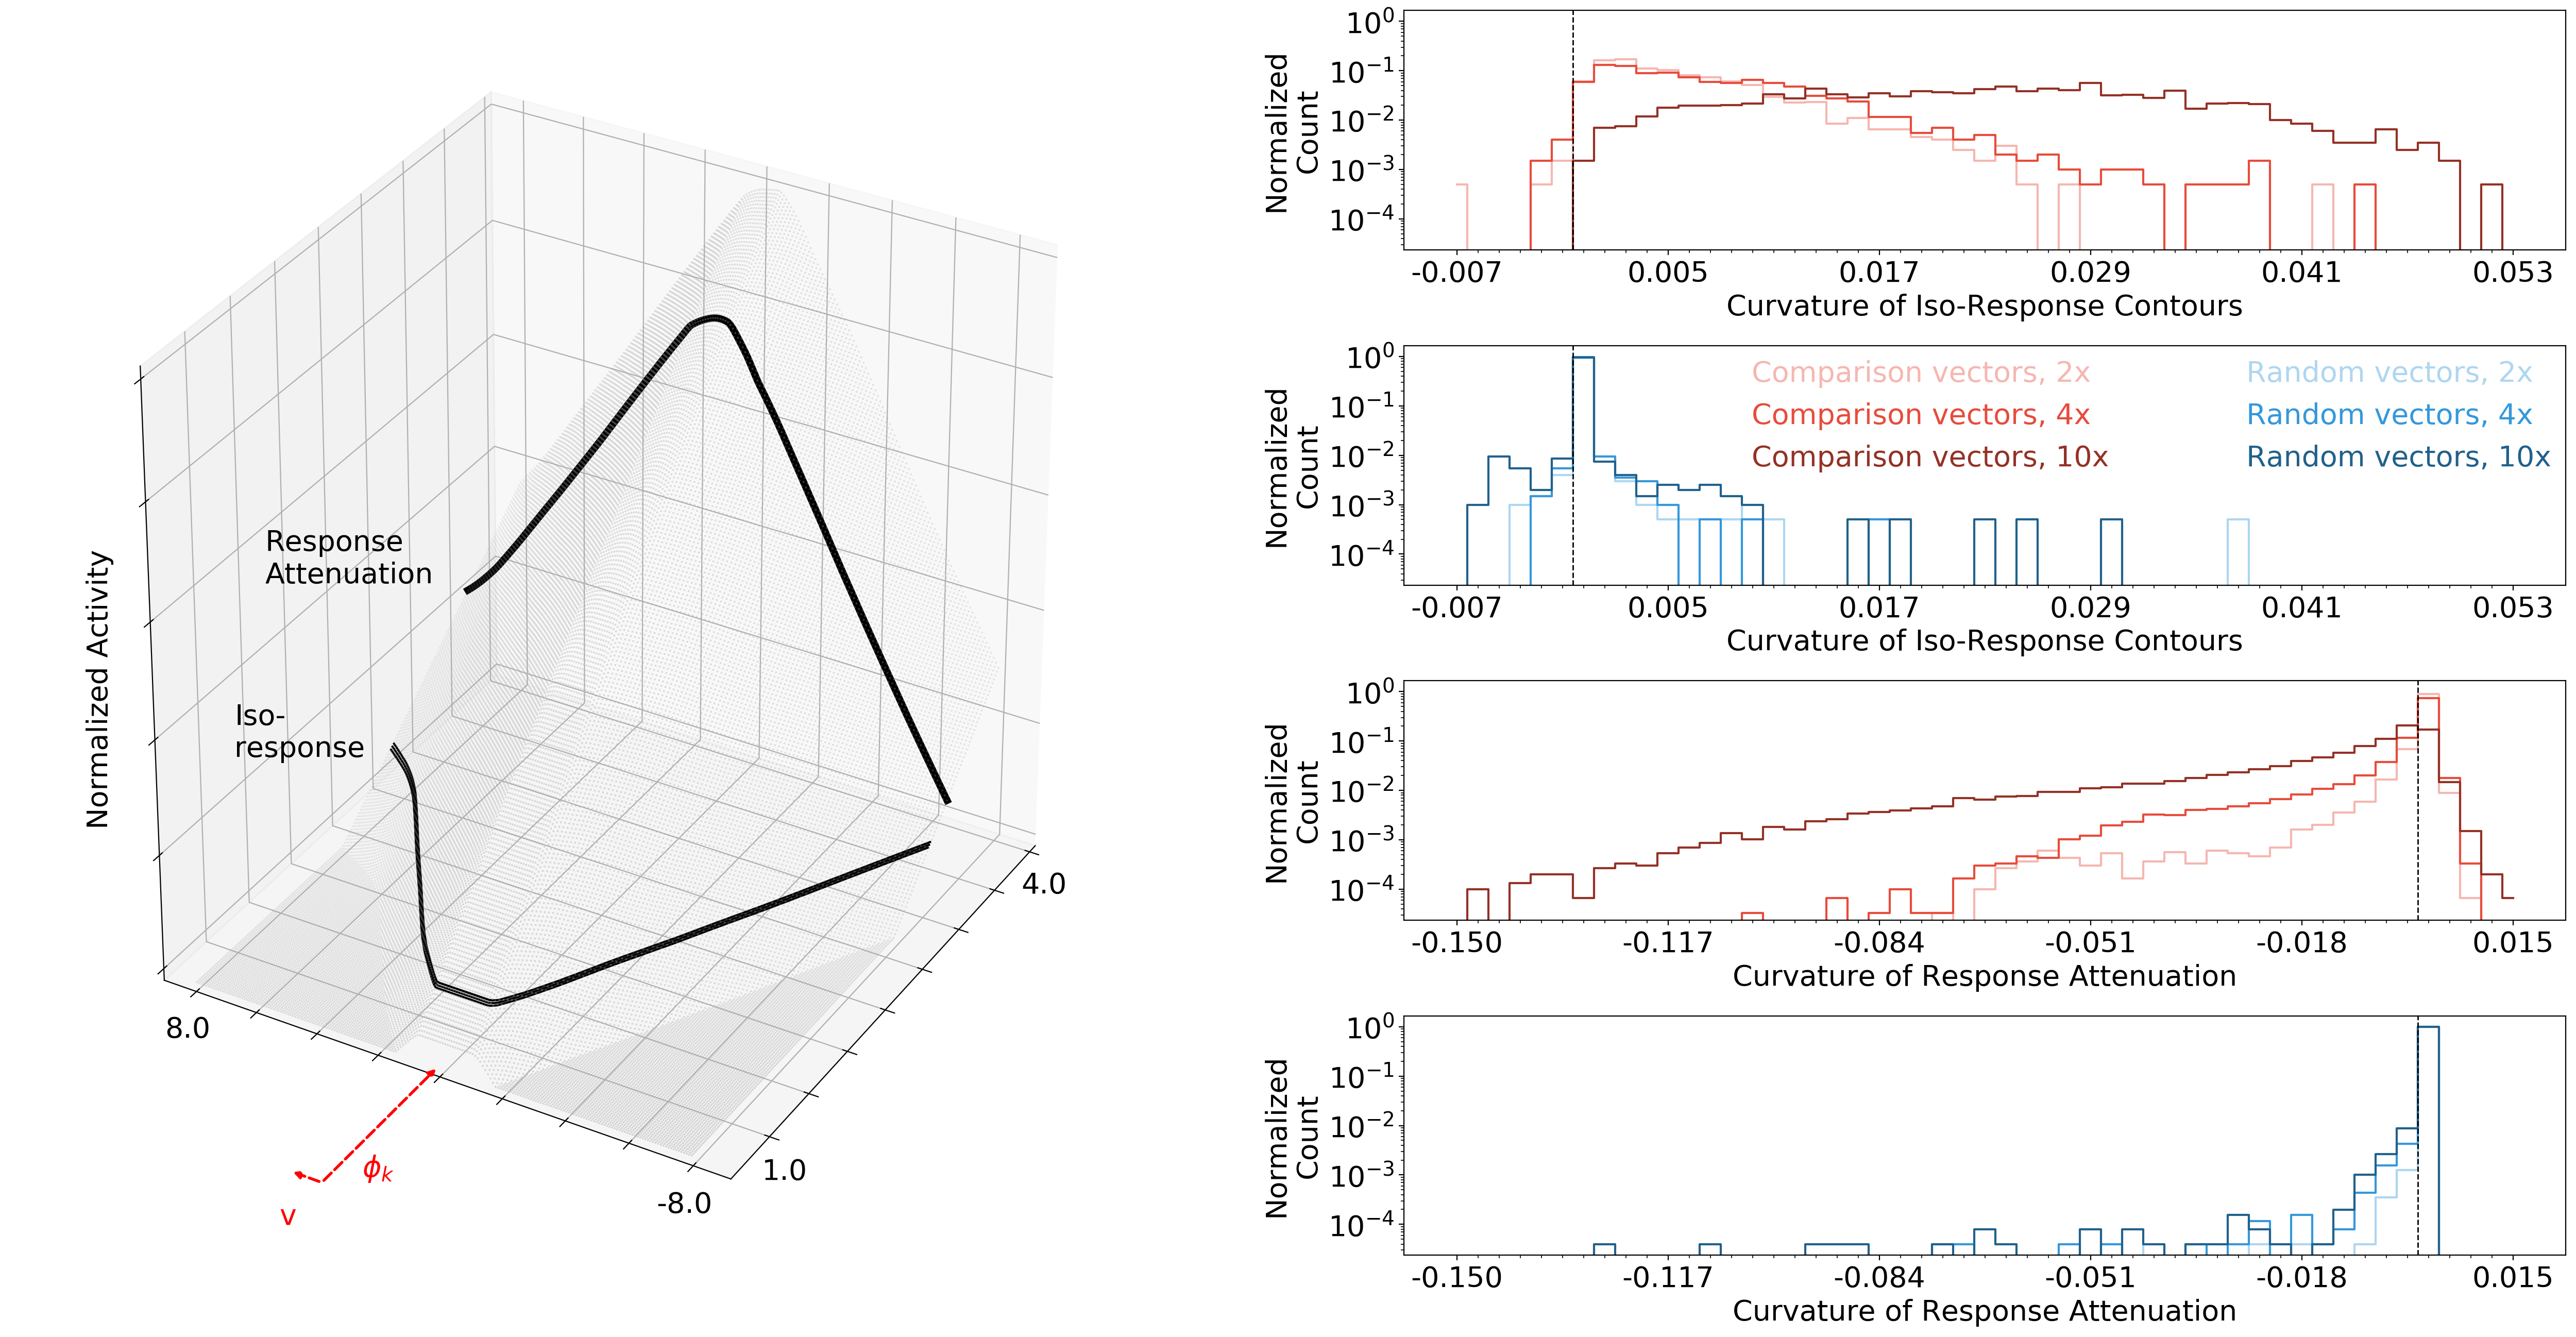

In [13]:
contour_angle = 210

full_hist_list = [iso_hist_list, attn_hist_list]
full_label_list = [label_list,]*2
full_color_list = [color_list,]*2
full_bin_centers = [iso_plot_bin_centers, attn_plot_bin_centers]
full_title = [iso_title, attn_title]
full_xlabel = [iso_xlabel, attn_xlabel]

iso_resp_loc = [0, 180, 0.42]
resp_att_loc = [100, 240, 0.38]
contour_text_loc = [iso_resp_loc, resp_att_loc]

curvature_fig = nc.plot_curvature_histograms(contour_activity, contour_pts, contour_angle, contour_text_loc,
  full_hist_list, full_label_list, full_color_list, full_bin_centers, full_title, full_xlabel,
  figsize=(2*figsize[0], figsize[1]), dpi=dpi, fontsize=fontsize)

for analyzer in analyzer_list:
  for ext in [".png"]:#, ".eps"]:
    save_name = (analyzer.analysis_out_dir+"/vis/curvatures_and_histograms"
      +"_"+analyzer.analysis_params.save_info+ext)
    curvature_fig.savefig(save_name, transparent=False, bbox_inches="tight", pad_inches=0.01, dpi=dpi)

### Orientation Selectivity

In [14]:
params_list = [rica_768_vh_params(), sae_768_vh_params(), lca_768_vh_params()]
params_list[-1].display_name = "Sparse Coding"
for params in params_list:
  params.model_dir = (os.path.expanduser("~")+"/Work/Projects/"+params.model_name)
analyzer_list = [ap.get_analyzer(params.model_type) for params in params_list]
for analyzer, params in zip(analyzer_list, params_list):
  analyzer.setup(params)
  analyzer.model.setup(analyzer.model_params)
  analyzer.load_analysis(save_info=params.save_info)
  analyzer.model_name = params.model_name

In [15]:
circ_var_list = []
for analyzer in analyzer_list:
  analyzer.bf_indices = np.random.choice(analyzer.ot_grating_responses["neuron_indices"], 12)
  num_orientation_samples = len(analyzer.ot_grating_responses['orientations'])
  corresponding_angles_deg = (180 * np.arange(num_orientation_samples) / num_orientation_samples) - 90
  corresponding_angles_rad = (np.pi * np.arange(num_orientation_samples) / num_orientation_samples) - (np.pi/2)
  analyzer.metrics_list = {"fwhm":[], "circ_var":[], "osi":[], "skipped_indices":[]}
  contrast_idx = -1
  for bf_idx in range(analyzer.bf_stats["num_outputs"]):
    ot_curve = nc.center_curve(analyzer.ot_grating_responses["mean_responses"][bf_idx, contrast_idx, :])
    if np.max(ot_curve) - np.min(ot_curve) == 0:
      analyzer.metrics_list["skipped_indices"].append(bf_idx)
    else:
      fwhm = nc.compute_fwhm(ot_curve, corresponding_angles_deg)
      analyzer.metrics_list["fwhm"].append(fwhm)
      circ_var = nc.compute_circ_var(ot_curve, corresponding_angles_rad)
      analyzer.metrics_list["circ_var"].append(circ_var)
      osi = nc.compute_osi(ot_curve)
      analyzer.metrics_list["osi"].append(osi)
  circ_var_list.append(np.array([val[2] for val in analyzer.metrics_list["circ_var"]]))

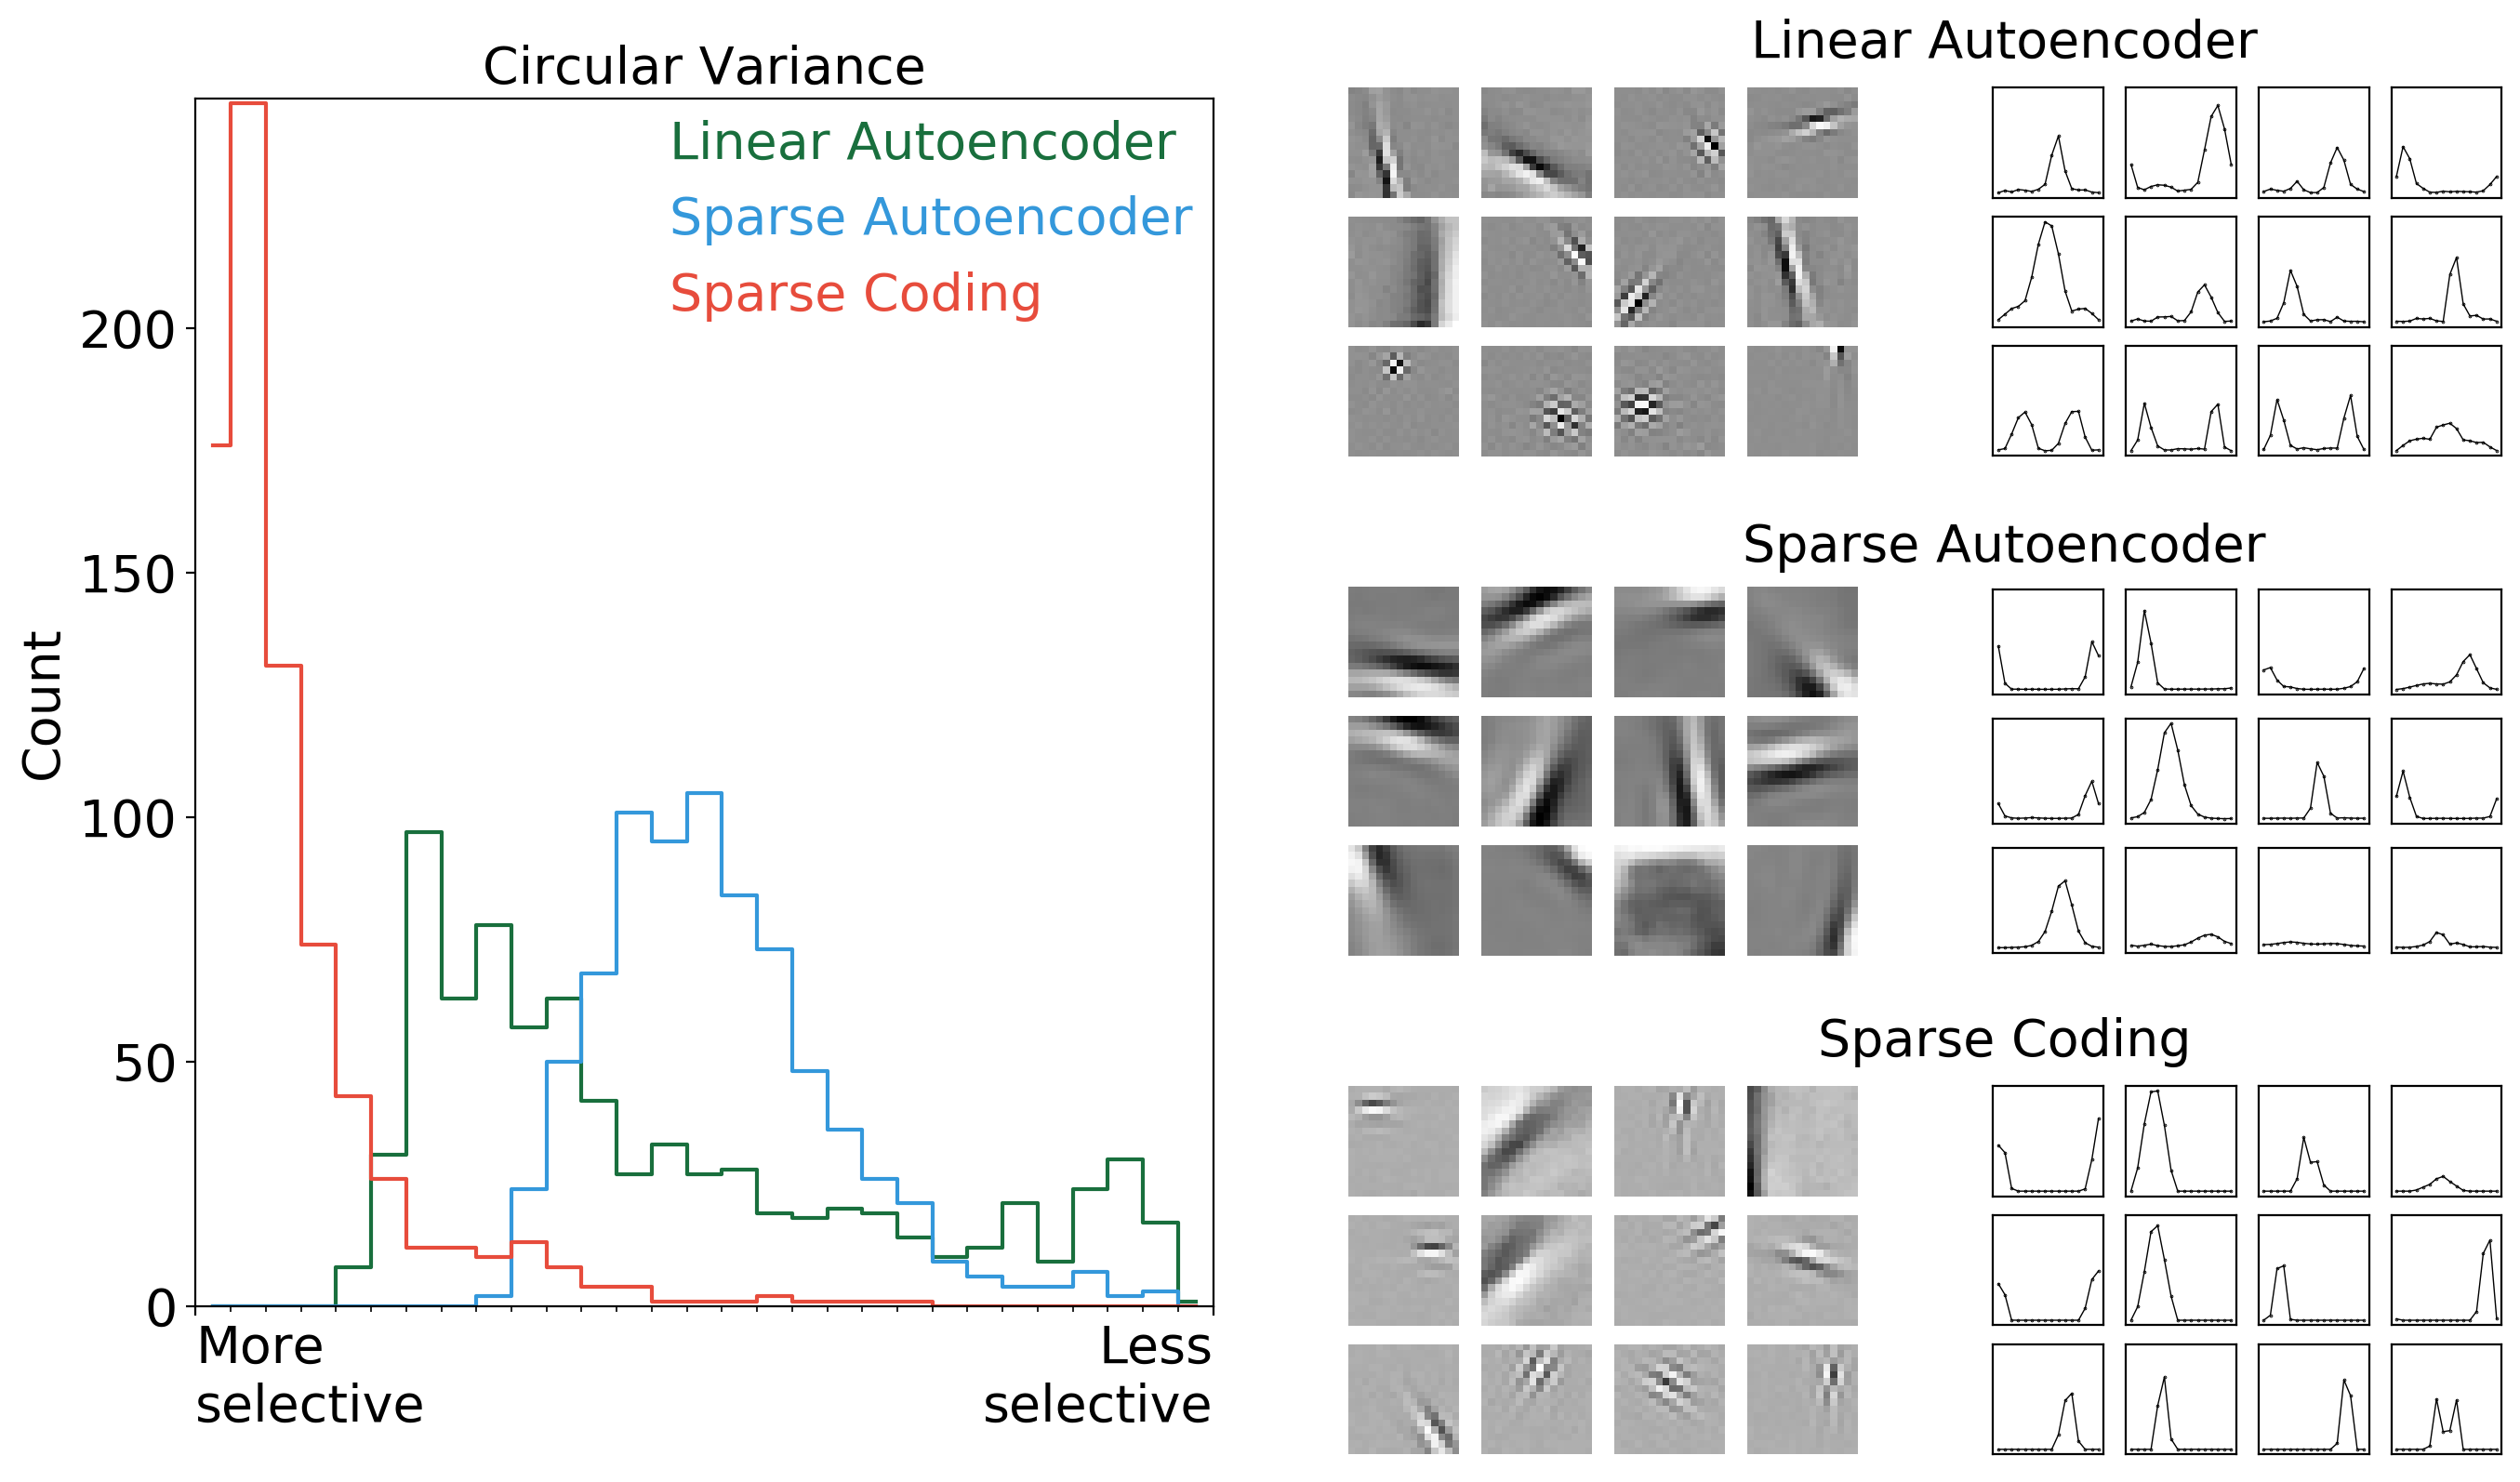

In [16]:
color_list = [color_vals["md_green"], color_vals["md_blue"], color_vals["md_red"]]
label_list = ["Linear Autoencoder", "Sparse Autoencoder", "Sparse Coding"]
num_bins = 30
width_ratios = [0.5, 0.25, 0.25]
height_ratios = [0.13, 0.25, 0.25, 0.25]

fig = nc.plot_circ_variance_histogram(analyzer_list, circ_var_list, color_list, label_list, num_bins, width_ratios, height_ratios, fontsize, figsize, dpi)

for analyzer in analyzer_list:
  for ext in [".png", ".eps"]:
    save_name = (analyzer.analysis_out_dir+"/vis/circular_variance_combo"
      +"_"+analyzer.analysis_params.save_info+ext)
    fig.savefig(save_name, transparent=False, bbox_inches="tight", pad_inches=0.01, dpi=dpi)

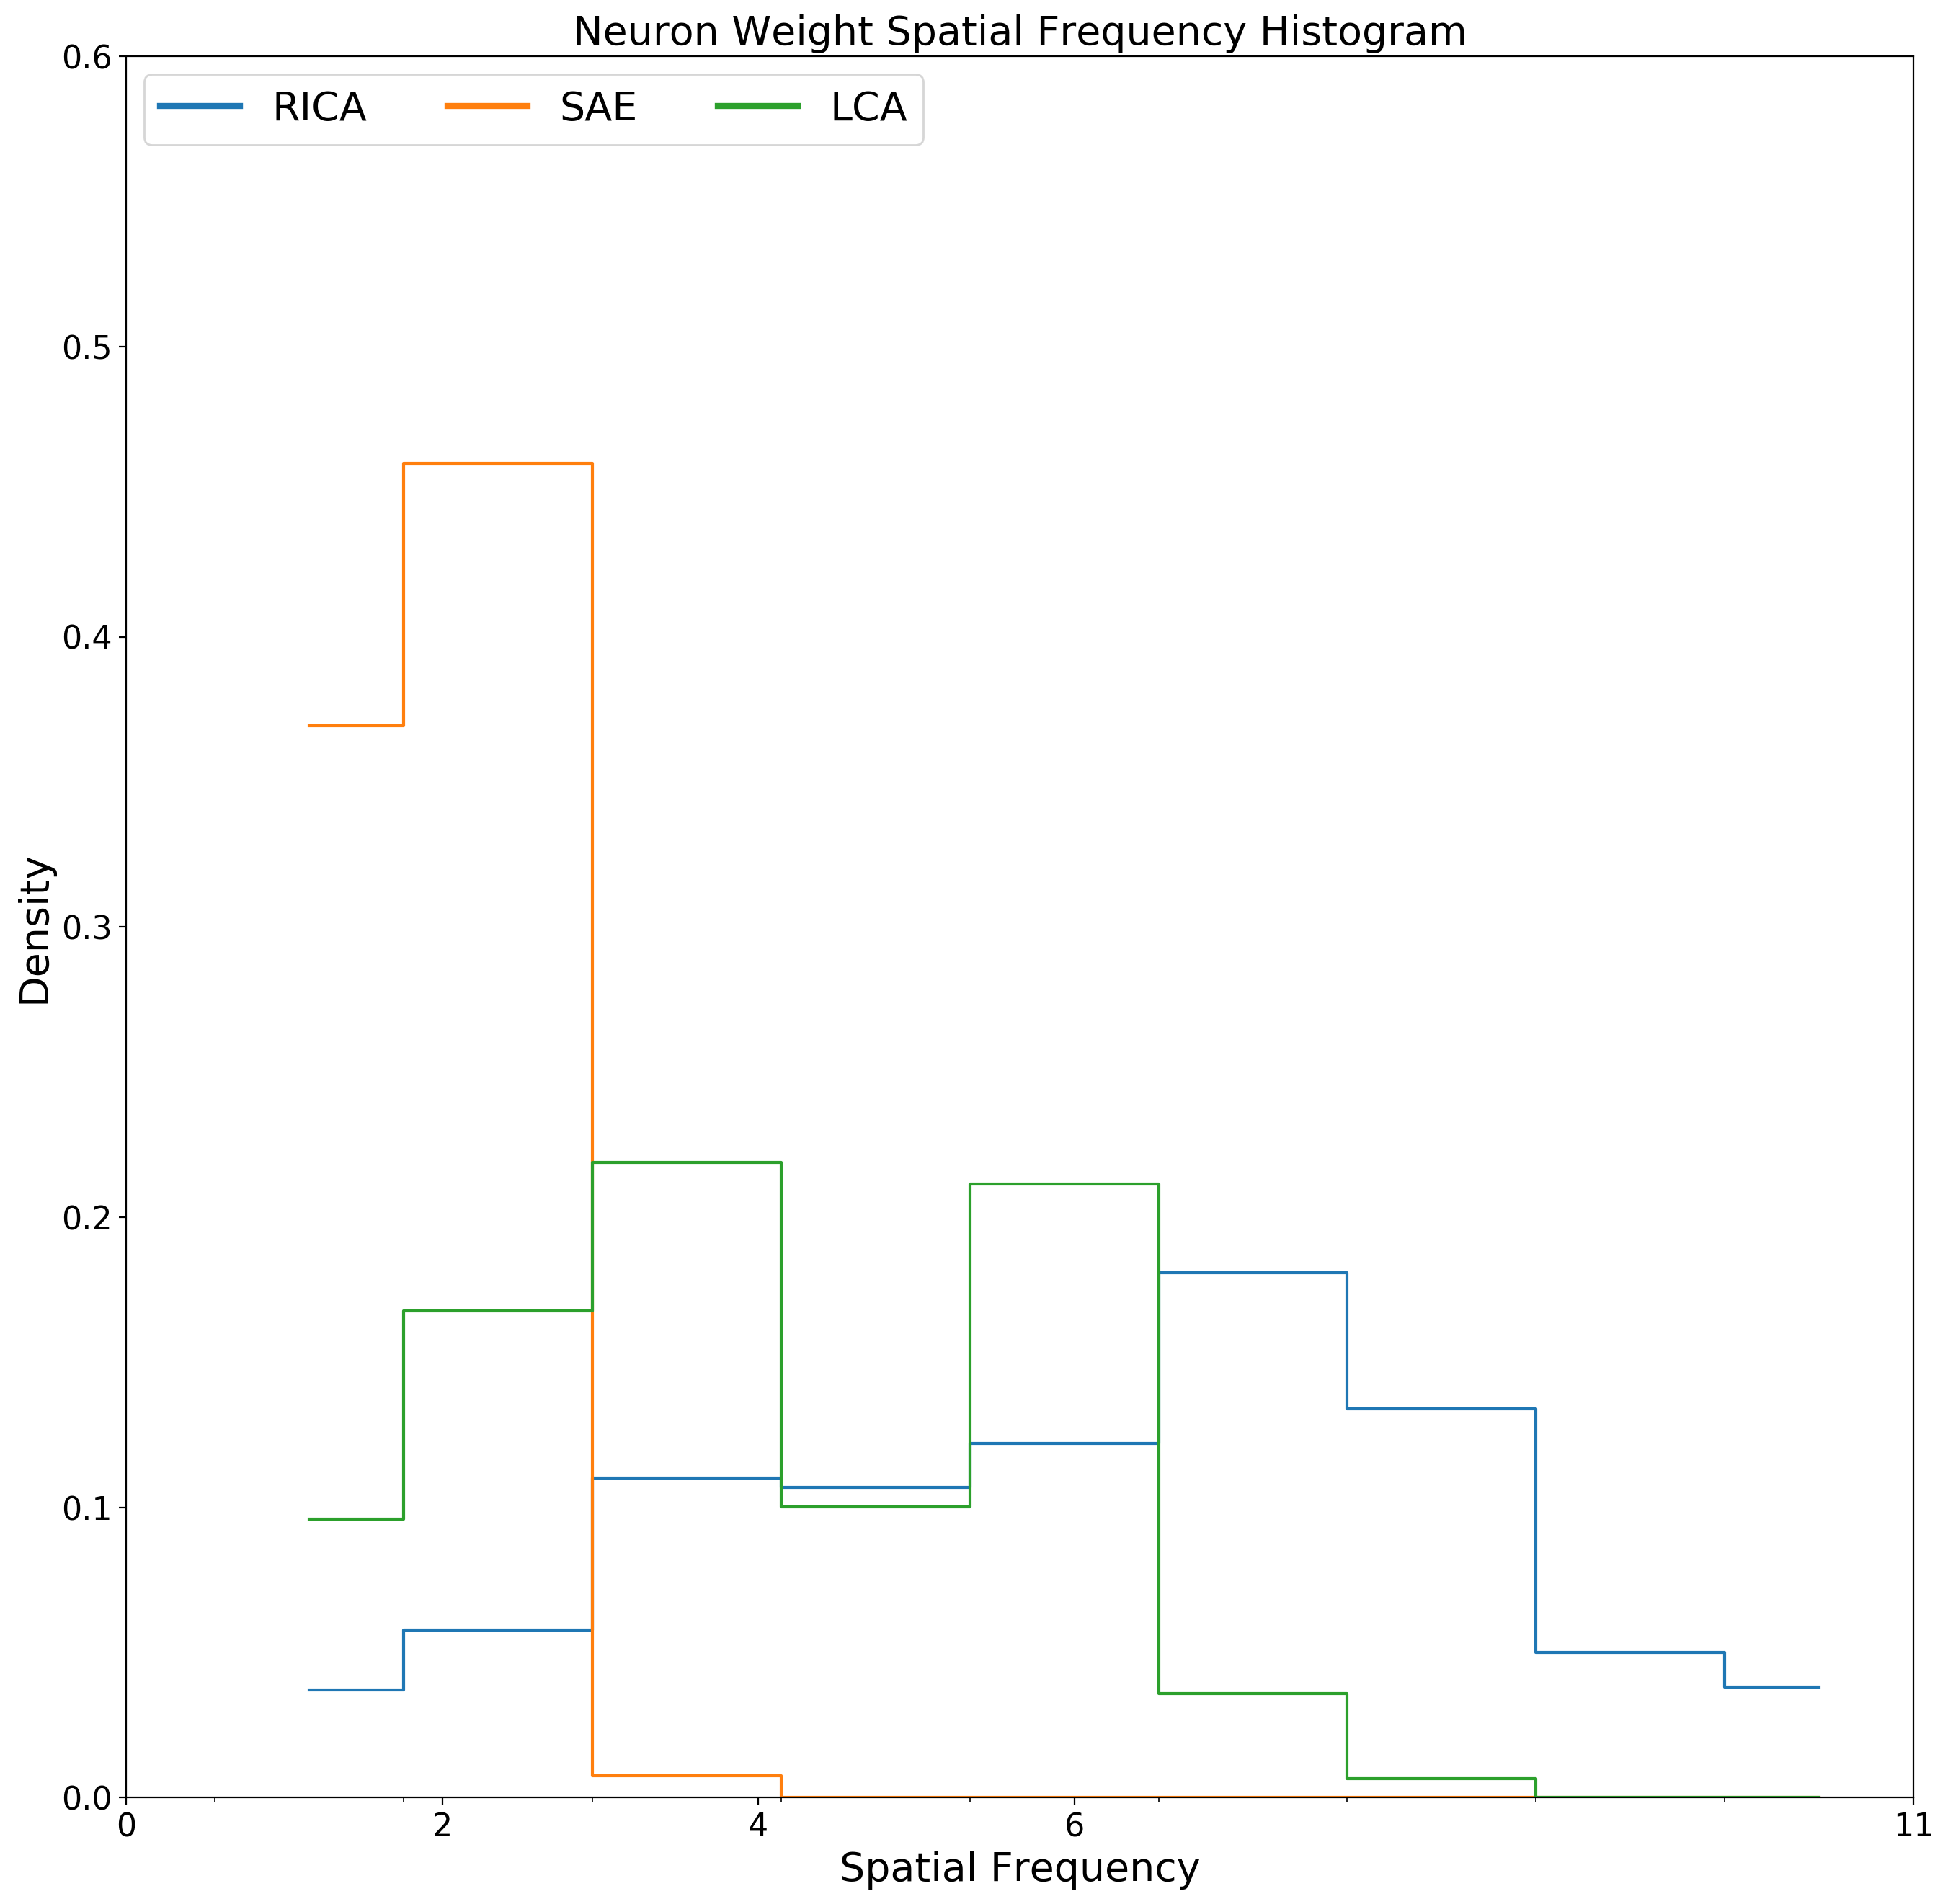

In [17]:
min_rads = []
max_rads = []
for analyzer in analyzer_list:
  analyzer.bf_spatial_freq_rads = [np.sqrt(x**2+y**2) for (y,x) in analyzer.bf_stats["fourier_centers"]]
  min_rads.append(np.min(analyzer.bf_spatial_freq_rads))
  max_rads.append(np.max(analyzer.bf_spatial_freq_rads))
  
num_bins = 10
min_rad = np.min(min_rads)
max_rad = np.max(max_rads)
bins = np.linspace(min_rad, max_rad, num_bins)
fig, ax = plt.subplots(1, figsize=figsize, dpi=dpi)
hist_max = []
for analyzer in analyzer_list:
  hist, bin_edges = np.histogram(analyzer.bf_spatial_freq_rads, bins, density=True)
  bin_left, bin_right = bin_edges[:-1], bin_edges[1:]
  bin_centers = bin_left + (bin_right - bin_left)/2
  
  label = analyzer.model.params.model_type.upper()# + " " + str(analyzer.model.get_num_latent())# + " van Hateren"
  #label = re.sub("_", " ", analyzer.model_name)
  ax.plot(bin_centers, hist, alpha=1.0, linestyle="-", drawstyle="steps-mid", label=label)
  hist_max.append(np.max(hist))
  
ax.set_xticks(bin_left, minor=True)
ax.set_xticks(bin_left[::4], minor=False)
ax.xaxis.set_major_formatter(FormatStrFormatter("%0.0f"))
ax.tick_params("both", labelsize=16)
ax.set_xlim([min_rad, max_rad])
ax.set_xticks([0, int(np.floor(max_rad/4)), int(2*np.floor(max_rad/4)),
  int(3*np.floor(max_rad/4)), max_rad])
ax.set_ylim([0, 0.6])
ax.set_xlabel("Spatial Frequency", fontsize=fontsize)
ax.set_ylabel("Density", fontsize=fontsize)
ax.set_title("Neuron Weight Spatial Frequency Histogram", fontsize=fontsize)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, fontsize=fontsize, ncol=3,
  borderaxespad=0., bbox_to_anchor=[0.01, 0.99], fancybox=True, loc="upper left")
for line in legend.get_lines():
  line.set_linewidth(3)
plt.show()    

## Targeted attacks on MLP & LCA network

In [18]:
path = "/home/dpaiton/Work/Projects/"

# kurakin analysis path
k_file_path = "/analysis/0.0/savefiles/class_adversary_analysis_test_kurakin_targeted.npz"
k_img_path = "/analysis/0.0/savefiles/class_adversary_images_analysis_test_kurakin_targeted.npz"

# carlini analysis path
c_file_path = "/analysis/0.0/savefiles/class_adversary_analysis_test_carlini_targeted.npz"
c_img_path = "/analysis/0.0/savefiles/class_adversary_images_analysis_test_carlini_targeted.npz"

# model names
lca_768_2layer = "slp_lca_768_latent_75_steps_mnist"
lca_768_3layer = "mlp_lca_768_latent_75_steps_mnist"
lca_1568_2layer = "slp_lca_1568_latent_75_steps_mnist"
lca_1568_3layer = "mlp_lca_1568_latent_75_steps_mnist"
mlp_768_2layer = "mlp_cosyne_mnist"
mlp_768_3layer = "mlp_3layer_cosyne_mnist"
mlp_1568_2layer = "mlp_1568_mnist"
mlp_1568_3layer = "mlp_1568_3layer_mnist"

stop_conf=.95
# bar chart files/parameters
lca_1568_files = [path + model_name + k_file_path for model_name in [lca_1568_2layer, lca_1568_3layer]]
lca_768_files = [path + model_name + k_file_path for model_name in [lca_768_2layer, lca_768_3layer]]
mlp_1568_files = [path + model_name + k_file_path for model_name in [mlp_1568_2layer, mlp_1568_3layer]]
mlp_768_files = [path + model_name + k_file_path for model_name in [mlp_768_2layer, mlp_768_3layer]]

xtick_labels = ['2-layer', '3-layer']
file_lists = [mlp_768_files, mlp_1568_files, lca_768_files, lca_1568_files]
metric = "input_adv_mses"
colors = ['blue', 'red', 'green', 'orange']
names = ['w/o LCA_768', 'w/o LCA_1568', 'w/ LCA_768', 'w/ LCA_1568']

# adv example image files/parameters
mlp_metric_files = [path +  file + k_file_path for file in [mlp_768_2layer, mlp_768_3layer]]
lca_metric_files = [path +  file + k_file_path for file in [lca_768_2layer, lca_768_3layer]]
mlp_img_files = [path +  file + k_img_path for file in [mlp_768_2layer, mlp_768_3layer]]
lca_img_files = [path +  file + k_img_path for file in [lca_768_2layer, lca_768_3layer]]

In [19]:
### Functions for finding MSE data
def std_conf(outputs, labels, index):
  return np.std(np.sum(outputs[index] * labels, axis=1))

def mean_conf(outputs, labels, index):
  return np.mean(np.sum(outputs[index] * labels, axis=1))

def find_avg_conf_step(analysis):
  outputs = analysis["adversarial_outputs"][0]
  target_labels = analysis["target_labels"]
  indices = len(outputs)
  confs = []
  for i in range(indices):
    confs.append(mean_conf(outputs, target_labels, i))
  return np.array(confs)

def find_mse(analysis):
  outputs = analysis["input_adv_mses"][0]
  indices = len(outputs)
  mean_mses = []; std_mses = []
  for i in range(indices):
    mean_mses.append(np.mean(outputs[i]))
    std_mses.append(np.std(outputs[i]))
  return np.array(mean_mses), np.array(std_mses)     

def find_conf_index(analysis, stop_conf):
  outputs = analysis["adversarial_outputs"][0]
  target_labels = analysis["target_labels"]
  confs = np.sum(outputs * target_labels, axis=-1)
  stop_indices = []
  for i in range(len(confs.T)):
    gt_stop_conf = np.where(confs.T[i] >= stop_conf)[0]
    if len(gt_stop_conf) > 0:
      stop_indices.append(gt_stop_conf[0])
    else:
      stop_indices.append(-1)
  return stop_indices

### Functions for the adv MSE bar plots
def get_rects(filename_list, metric, stop_conf):
  data = []; means = []; stds = [];
  for file in filename_list:
    metrics = np.load(file, allow_pickle=True)["data"].item()
    stop_indices = find_conf_index(metrics, stop_conf)
    MSE = metrics[metric][0, stop_indices, np.arange(metrics[metric][0].shape[-1])]
    data.append(MSE)
    means.append(np.mean(MSE))
    stds.append(np.std(MSE)) 
  return data, means, stds

def multi_model_compare(ax, data, means, stds, colors, names, xtick_labels,
                        xlabel, ylabel, ylim, width, title, fontsize):
  # orgnaize the data
  cmap_gray = cm.get_cmap("gray")
  N = len(data[0]) # number of depths
  M = len(data) # number of models being compared
  # create the bar chart
  ind = np.arange(N)  # the x locations for the depths    
  rects = []
  for i in range(M):
    # the bars
    x = ind + i * (width+.01)
    rect = ax.bar(x, means[i], color=colors[i], yerr = stds[i], width=width, alpha=1.0)
    rects.append(rect)
    # the data points
    bar_data = np.array(data[i])
    x_tiled = np.tile(x+(width/4), (bar_data.shape[-1],1)).T
    ax.scatter(x_tiled, bar_data, color='black', alpha=1.0, s=1, zorder=2)
  ax.set_xticks(ind + ((M-1)*(width+.01))/2)
  ax.set_xticklabels(xtick_labels, fontsize=fontsize)
  ax.set_ylabel(ylabel, fontsize=fontsize)
  ax.set_xlabel(xlabel, fontsize=fontsize)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.yaxis.grid(which="major", color=cmap_gray(.8), linestyle='--', linewidth=1)
  ax.tick_params("both", labelsize=fontsize)
  ax.set_axisbelow(True)
  ax.set_ylim([0, ylim])
  ax.set_title(title, fontsize=fontsize)
  ax.legend([r[0] for r in rects], names, fontsize=fontsize, loc='upper right')
  return data

def get_flat_mnist_mse_data(file_list, metric, stop_conf):
  return get_rects(file_list, metric, stop_conf)

def get_mnist_mse_data(file_lists, metric, stop_conf):
  """
  Params
  ------
  file_lists: list
      list of list with organization
      inner list: model-type filenames (i.e. lca or mlp)
      outer lists: groups across models (i.e. layer depth)
  metric: str
      the analysis metric to average over
  stop_conf: float
      the desired classifier confidence for stopping the adversarial attack
  """
  data = []; means = []; stds = []
  for file_list in file_lists:
    data_step, means_step, stds_step = get_rects(file_list, metric, stop_conf) 
    means.append(means_step)
    data.append(data_step)
    stds.append(stds_step)
  return (data, means, stds)
  
def adv_mse_comparison_plot(ax, file_lists, metric, stop_conf,
                            colors, names, xtick_labels, xlabel, ylabel, ylim, width, title, fontsize):
  """
  Bar chart that compares a designated metric for each model in file_lists
  
  Params
  ------
  file_lists: list
      list of list with organization
      inner list: model-type filenames (i.e. lca or mlp)
      outer lists: groups across models (i.e. layer depth)
  metric: str
      the analysis metric to average over
  stop_conf: float
      the desired classifier confidence for stopping the adversarial attack
  colors: list
      list of matplotlib color codes for each model
  xtick_labels: list
      list of the group labels (i.e. layer depths)
  names: list
      names of the models (i.e. lca or mlp)
  xlabel: str
      x axis label
  """
  data, means, stds = get_mnist_mse_data(file_lists, metric, stop_conf)
  return multi_model_compare(ax, data, means, stds, colors, names, xtick_labels, xlabel, ylabel, ylim, width, title, fontsize)

### Visualizing adv examples plotting code
def stitch(img1, img2, axis):
  img1 = img1.reshape(28,28)
  img2 = img2.reshape(28,28)
  if axis==0:
    out = np.vstack((img1, img2))
  elif axis==1:
    out = np.hstack((img1, img2))
  return out

def show(axis, image, clf):
  im = axis.imshow(image, cmap="Greys", interpolation="nearest", vmin=0, vmax=1)
  for spine in axis.spines.values():
    spine.set_visible(False)
  axis.tick_params(
    axis="both",
    bottom="off",
    top="off", 
    left="off",
    right="off")
  axis.set_xticks([])
  axis.set_yticks([])
  props = dict(facecolor='white', alpha=1)
  if clf is not None:
    axis.text(.05, .95, str(clf), fontsize=8, bbox=props,
      verticalalignment='center', color = "black")
  return im 

def get_results(metric_files, img_files, stop_conf):
  imgs = [np.load(file, allow_pickle=True)["data"].item() for file in img_files]
  metrics = [np.load(file, allow_pickle=True)["data"].item() for file in metric_files]
  indices = [np.array(find_conf_index(r, stop_conf)) for r in metrics]
  input_images = [r["input_images"] for r in metrics]
  input_clf = [np.argmax(r["input_labels"], axis=1) for r in metrics]
  adv_images = [r["adversarial_images"][0, i, np.arange(len(i)), :] for i, r in zip(indices,imgs)]
  adv_clf = [np.argmax(r["adversarial_outputs"][0, i, np.arange(len(i))], axis=1)
    for i, r in zip(indices,metrics)]
  return input_images, input_clf, adv_images, adv_clf

### Example image plotting code
def show_example(ax, grp1_imgs, grp1_metrics, grp2_imgs, grp2_metrics, stop_conf, grp_names):
  """
  shows adv examples
  Params
  -------
  size: int
      the number of examples to show
  grp1_imgs: list
      list of image files for group 1 (i.e mlp models)
  grp1_metrics: list: list
      list of metric files for group 1 
  grp_names: list
      list of the group name (e.g. "Unperturbed", "2-layer")
  """
  size = ax.shape[0]
  input_images, _, adv_grp1, adv_clf = get_results(grp1_metrics, grp1_imgs, stop_conf)
  _, _, adv_grp2, _ = get_results(grp2_metrics, grp2_imgs, stop_conf)
  adv = [(img1, img2) for img1, img2 in zip(adv_grp1, adv_grp2)]
  start = 0
  for i in range(start,start+size): # figure rows
    for j in range(0, len(grp1_metrics)+1): #figure columns
      if j == 0:
        if i == start:
            ax[i-start, j].set_title(grp_names[j])
        unper_data = input_images[j][i]
        unper_im = show(ax[i-start,j], unper_data.reshape(28,28), None)
      else:
        if i == start:
          ax[i-start, j].set_title(grp_names[j])
        img1, img2 = adv[j-1]
        stitched_image = stitch(img1[i],img2[i],1)
        im = show(ax[i-start,j], stitched_image, adv_clf[j-1][i])
        # only display color bar on last column
        if j == len(grp1_metrics):
          pf.add_colorbar_to_im(im, aspect=20, ax=ax[i-start,j],
                                ticks=[np.min(stitched_image), np.max(stitched_image)])
          #fig.colorbar(im, ax=ax[i-start,j], ticks=[np.min(stitched_image), np.max(stitched_image)])
        ax[i-start, j].set_xlabel("w/o LCA             w/ LCA")

### MSE bar chart plotting code

## Figure: MSE bar chart + example images

In [20]:
path = "/home/dpaiton/Work/Projects/"

# kurakin analysis path
k_file_path = "/analysis/0.0/savefiles/class_adversary_analysis_test_kurakin_targeted.npz"
k_img_path = "/analysis/0.0/savefiles/class_adversary_images_analysis_test_kurakin_targeted.npz"

# carlini analysis path
c_file_path = "/analysis/0.0/savefiles/class_adversary_analysis_test_carlini_targeted.npz"
c_img_path = "/analysis/0.0/savefiles/class_adversary_images_analysis_test_carlini_targeted.npz"

# model names
lca_768_2layer = "slp_lca_768_latent_75_steps_mnist"
lca_768_3layer = "mlp_lca_768_latent_75_steps_mnist"
lca_1568_2layer = "slp_lca_1568_latent_75_steps_mnist"
lca_1568_3layer = "mlp_lca_1568_latent_75_steps_mnist"
mlp_768_2layer = "mlp_cosyne_mnist"
mlp_768_3layer = "mlp_3layer_cosyne_mnist"
mlp_1568_2layer = "mlp_1568_mnist"
mlp_1568_3layer = "mlp_1568_3layer_mnist"

# bar chart files/parameters
lca_1568_files = [path + model_name + k_file_path for model_name in [lca_1568_2layer, lca_1568_3layer]]
lca_768_files = [path + model_name + k_file_path for model_name in [lca_768_2layer, lca_768_3layer]]
mlp_1568_files = [path + model_name + k_file_path for model_name in [mlp_1568_2layer, mlp_1568_3layer]]
mlp_768_files = [path + model_name + k_file_path for model_name in [mlp_768_2layer, mlp_768_3layer]]

xtick_labels = ['2-layer', '3-layer']
file_lists = [mlp_768_files, mlp_1568_files, lca_768_files, lca_1568_files]
metric = "input_adv_mses"
colors = ['blue', 'red', 'green', 'orange']
names = ['w/o LCA_768', 'w/o LCA_1568', 'w/ LCA_768', 'w/ LCA_1568']

# adv example image files/parameters
mlp_metric_files = [path +  file + k_file_path for file in [mlp_768_2layer, mlp_768_3layer]]
lca_metric_files = [path +  file + k_file_path for file in [lca_768_2layer, lca_768_3layer]]
mlp_img_files = [path +  file + k_img_path for file in [mlp_768_2layer, mlp_768_3layer]]
lca_img_files = [path +  file + k_img_path for file in [lca_768_2layer, lca_768_3layer]]

# adv stop confidence
stop_conf = .95

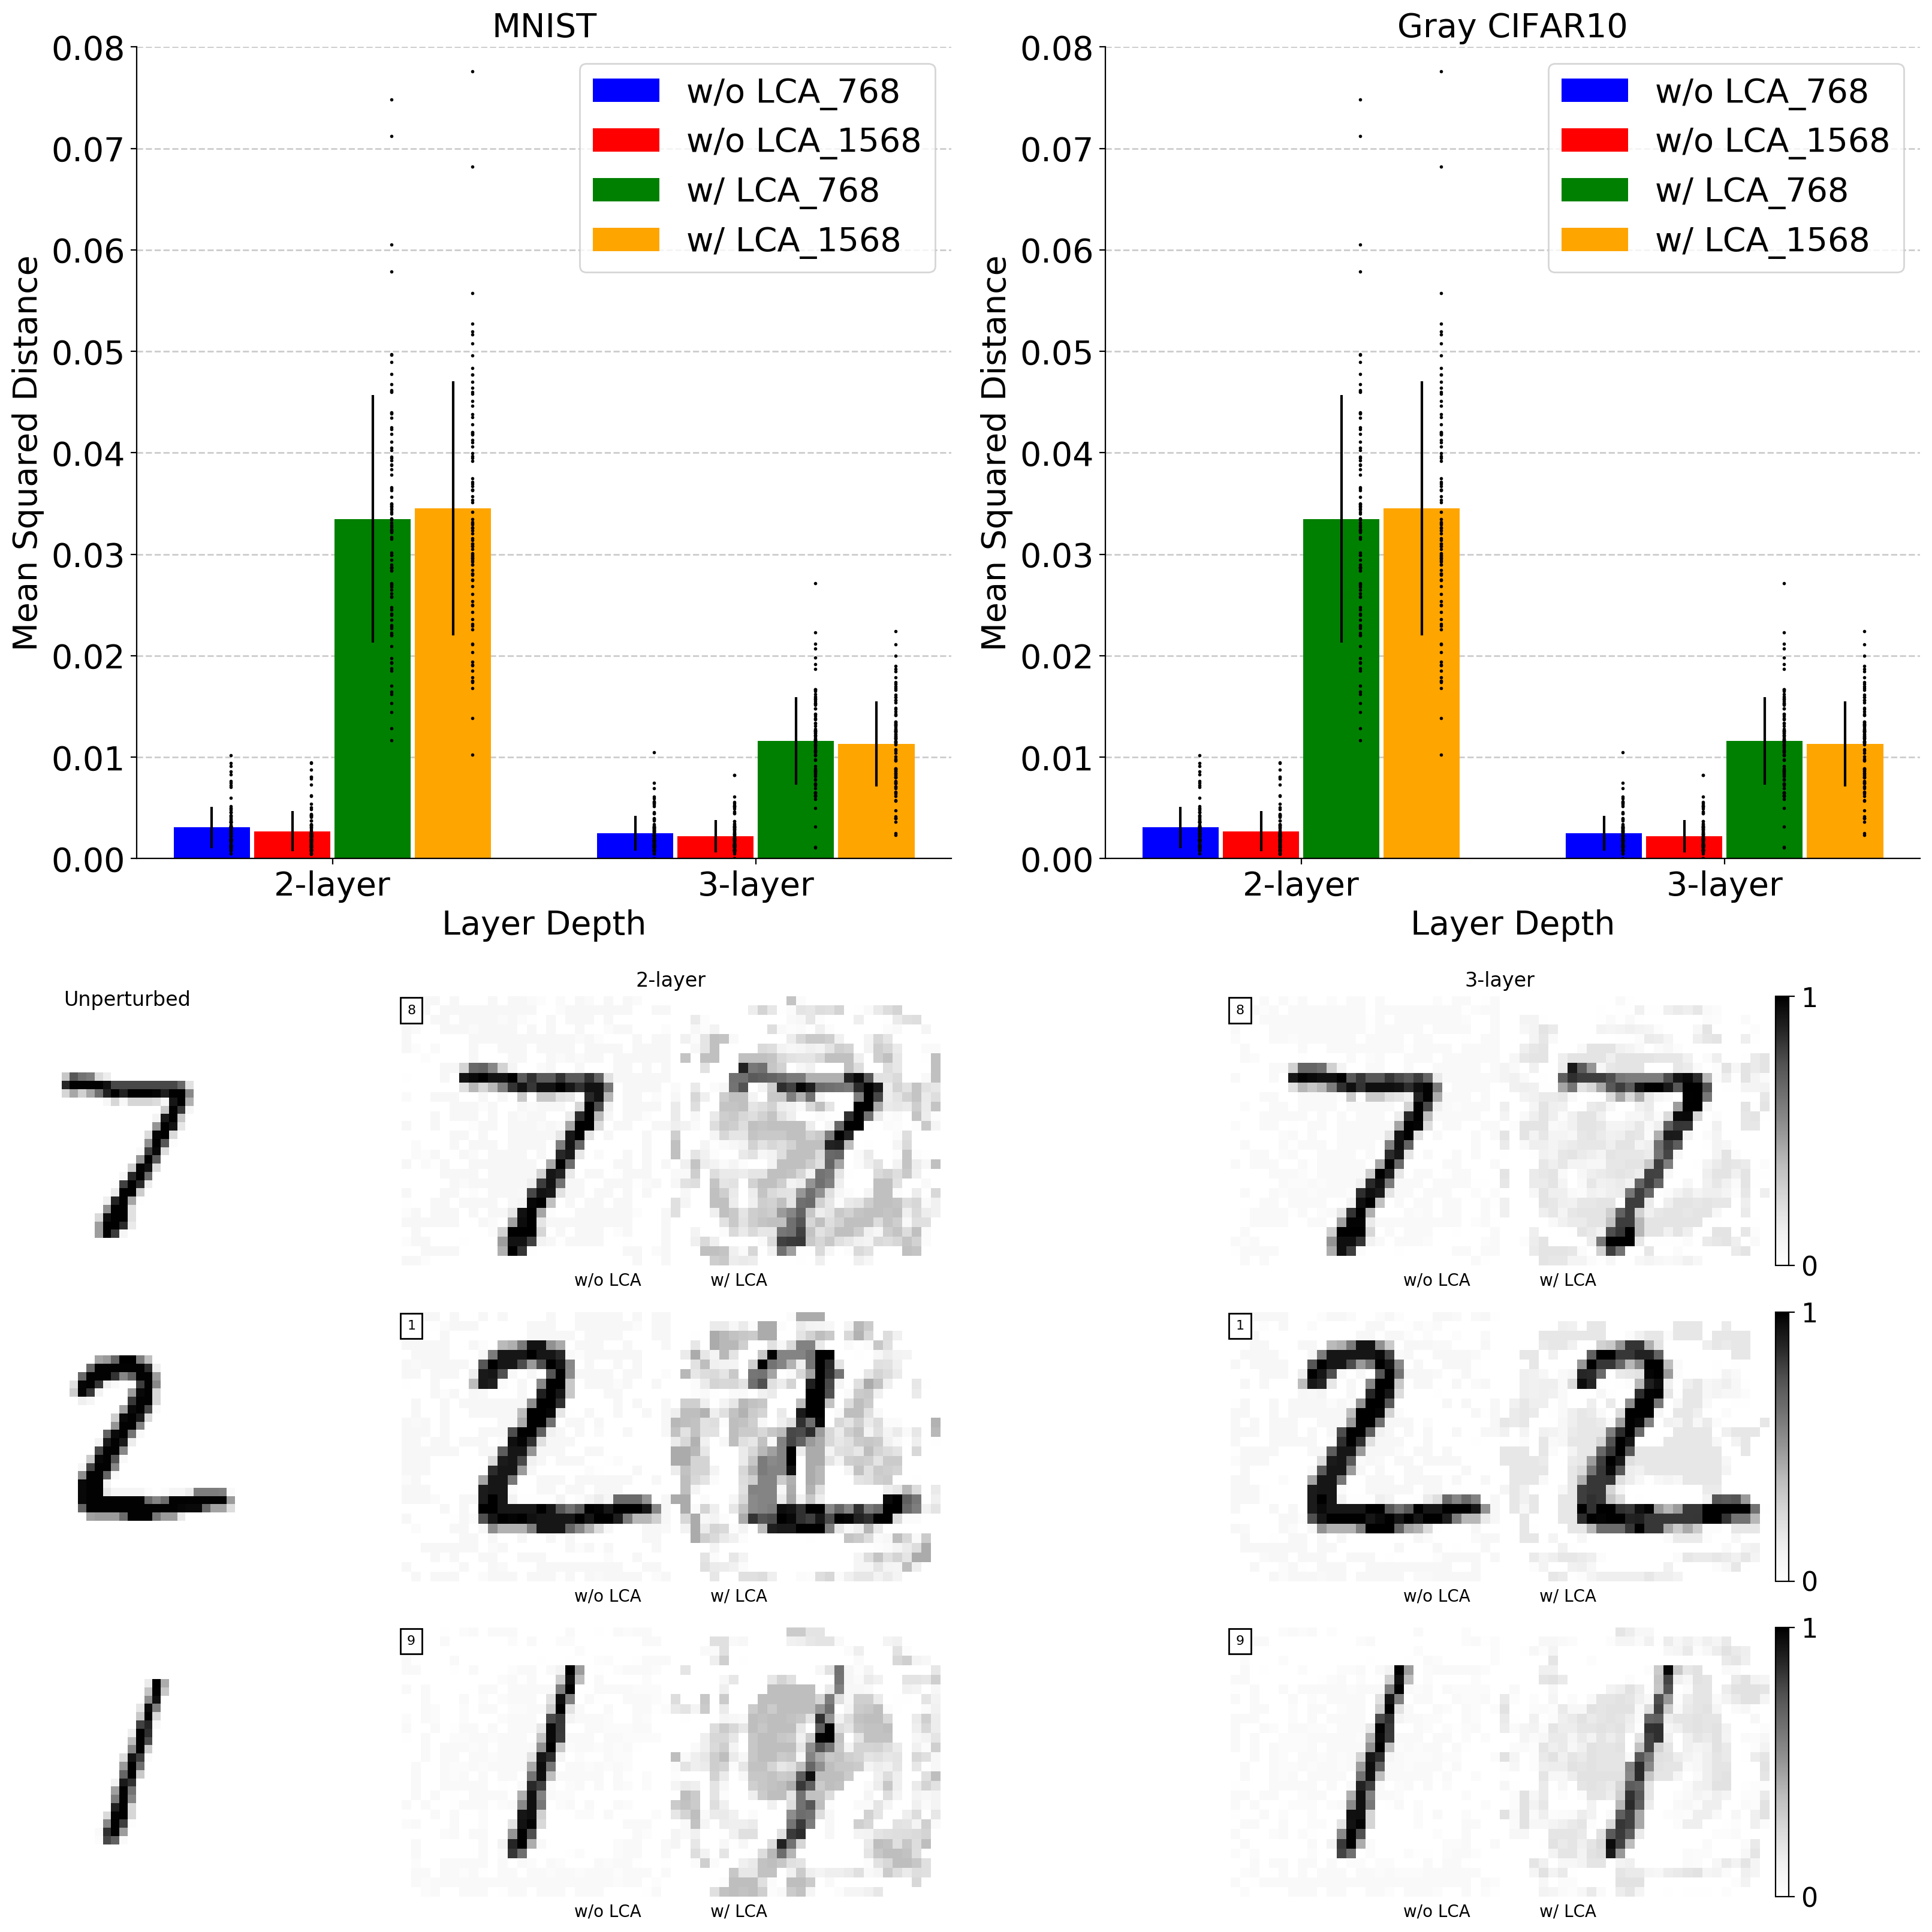

In [21]:
text_width = 7.2
fig = plt.figure(constrained_layout=True, figsize=figsize, dpi=dpi)#(text_width, text_width/2))

#gs = plt.GridSpec(3, 7, figure=fig)
#
## MSE bar chart
#ax1 = fig.add_subplot(gs[:, :2])
#data_points = adv_mse_comparison_plot(ax1, file_lists, metric, stop_conf, colors, names,
#                                      xtick_labels, xlabel="Layer Depth", 
#                                      ylabel="Mean Squared Distance", ylim=0.08,
#                                      width=.18, fontsize=fontsize)
## Example images
#ax2 = fig.add_subplot(gs[0, 2])
#ax3 = fig.add_subplot(gs[0, 3:5])
#ax4 = fig.add_subplot(gs[0, 5:])
#
#ax5 = fig.add_subplot(gs[1, 2])
#ax6 = fig.add_subplot(gs[1, 3:5])
#ax7 = fig.add_subplot(gs[1,5:])
#
#ax8 = fig.add_subplot(gs[2, 2])
#ax9 = fig.add_subplot(gs[2, 3:5])
#ax10 = fig.add_subplot(gs[2, 5:])
#
#image_axes = np.array([[ax2, ax3, ax4], [ax5, ax6, ax7], [ax8, ax9, ax10]])

gs0 = plt.GridSpec(2, 2, figure=fig)
ax0 = fig.add_subplot(gs0[0, 0])
data_points0 = adv_mse_comparison_plot(ax0, file_lists, metric, stop_conf, colors, names,
  xtick_labels, xlabel="Layer Depth", ylabel="Mean Squared Distance", ylim=0.08,
  width=.18, title="MNIST", fontsize=fontsize)

ax1 = fig.add_subplot(gs0[0, 1])
data_points1 = adv_mse_comparison_plot(ax1, file_lists, metric, stop_conf, colors, names,
  xtick_labels, xlabel="Layer Depth", ylabel="Mean Squared Distance", ylim=0.08,
  width=.18, title="Gray CIFAR10", fontsize=fontsize)

gs_images = gridspec.GridSpecFromSubplotSpec(3, 5, gs0[1,:])#, hspace=-0.6)
ax2 = fig.add_subplot(gs_images[0, 0])
ax3 = fig.add_subplot(gs_images[0, 1:3])
ax4 = fig.add_subplot(gs_images[0, 3:])

ax5 = fig.add_subplot(gs_images[1, 0])
ax6 = fig.add_subplot(gs_images[1, 1:3])
ax7 = fig.add_subplot(gs_images[1, 3:])

ax8 = fig.add_subplot(gs_images[2, 0])
ax9 = fig.add_subplot(gs_images[2, 1:3])
ax10 = fig.add_subplot(gs_images[2, 3:])

image_axes = np.array([[ax2, ax3, ax4], [ax5, ax6, ax7], [ax8, ax9, ax10]])


show_example(image_axes, mlp_img_files, mlp_metric_files, lca_img_files, lca_metric_files,
             stop_conf, ["Unperturbed"]+xtick_labels)

plt.show()
# fig.savefig(path+"adv_mse_examples.png", dpi=600)

## CIFAR plot

In [22]:
def get_cifar_mse_data(saved_info, model_names):
  data = []; means = []; stds = []
  for model_name in model_names:
    target_adv_mses = saved_info[model_name]["target_adv_mses"]
    data.append(target_adv_mses)
    means.append(np.mean(target_adv_mses))
    stds.append(np.std(target_adv_mses))
  return (data, means, stds)
  
def construct_conf_control_plot(saved_info, model_names, bar_groups,
  inner_group_names, outer_group_names, bar_width=.4, conf_thresh=.9):
  """
  saved_info: A dictionary of dictionaries, with the outer dictionary containing
    the name of the model, and the inner dictionary containing the model stats (target_adv_mses)
  model_names: A list of model names that's the key into saved_info
  bar_groups: An m by n array of indices into model_names
    that denotes which bars should be grouped (if flattened, bar indices goes from
    left to right)
  inner_group_names: A list of n strings denoting the label of inner group names
    (legend labels)
  outer_group_names: A list of m strings denoting the label of outer group names
    (x axis labels)
  bar_width: Sets the width of the bars in the bar plot
  conf_thresh: A float denoting the confidence threshold used (only used in the
    plot title) TODO remove this param
  """
  COLORS = [
    [1.0, 0.0, 0.0], #"r"
    [0.0, 0.0, 1.0], #"b"
    [1.0, 0.5, 0.5], #"dark r"
    [0.0, 0.0, 0.5], #"light b"
    [0.5, 0.5, 1.0], #"dark b"

    [0.0, 1.0, 0.0], #"g"
    [0.5, 1.0, 0.5], #"dark g"
    [0.0, 1.0, 1.0], #"c"
    [1.0, 0.0, 1.0], #"m"
    [1.0, 1.0, 0.0], #"y"
    [0.0, 0.0, 1.0], #"k"
    ]
  vals, means, errs = get_cifar_mse_data(saved_info, model_names)
  color = []; n = []
  for model_idx, model_name in enumerate(model_names):
    color.append(COLORS[model_idx])
    n.append(vals[model_idx].shape[0])
  num_groups = len(bar_groups)
  num_per_group = len(bar_groups[0])
  bar_groups = np.array(bar_groups)
  #Plot bar of ave mse per model
  fig, ax = plt.subplots(figsize=figsize)
  for i_g in range(num_per_group):
    group_means = [means[i] for i in bar_groups[:, i_g]]
    group_err = [errs[i] for i in bar_groups[:, i_g]]
    group_vals = [vals[i] for i in bar_groups[:, i_g]]
    group_n = [n[i] for i in bar_groups[:, i_g]]
    x_pos = np.arange(num_groups) + i_g * bar_width
    ax.bar(x_pos, group_means, width=bar_width, yerr=group_err,
      label=inner_group_names[i_g], color=color[i_g], alpha=.5)
    #data points
    #TODO do we want to sample here?
    for i_gg in range(num_groups):
      pos = np.tile(x_pos[i_gg]+(bar_width/4), (group_vals[i_gg].shape[0]))
      ax.scatter(pos, group_vals[i_gg], color='black', s=1, zorder=2)
    #for i_gg in range(num_groups):
    #  ax.text(x_pos[i_gg] + (bar_width/2.0), group_vals[i_gg],
    #    "n="+str(group_n[i_gg]), ha='center', va='bottom')
  plt.xlabel('Layers', fontsize=fontsize)
  plt.xticks([r + (bar_width)/2 for r in range(num_groups)], outer_group_names)
  plt.legend(fontsize=fontsize)
  #plt.xticks(rotation='vertical')
  #ax.set_xlabel("Model")
  ax.set_ylabel("Input Adv MSE", fontsize=fontsize)
  ax.set_title("Average MSE at confidence level "+str(conf_thresh), fontsize=fontsize)
  #plt.tight_layout()
  plt.show()
  return fig

## Combined plot

In [23]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])
    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

In [24]:
def make_violin(ax, group_data, group_means, x_pos, bar_width, color='k', plot_means=True, plot_medians=False):
  for data, means, pos in zip(group_data, group_means, x_pos):
    parts = ax.violinplot(data, [pos], widths=bar_width,
      showmeans=False, showextrema=False, showmedians=False, bw_method="silverman")#, bw_method=0.5)
    for pc in parts['bodies']:
      pc.set_facecolor(color)
      pc.set_edgecolor('k')
      pc.set_alpha(1)
    quartile1, medians, quartile3 = np.percentile(np.array(data), [25, 50, 75])#, axis=1)
    whiskers = np.array([adjacent_values(data, quartile1, quartile3)])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]
    if plot_medians:
      ax.scatter(pos, medians, marker='o', color='white', s=10, zorder=3, alpha=1)
    if plot_means:
      ax.scatter(pos, means, marker='o', color='white', s=10, zorder=3, alpha=1)
    ax.vlines(pos, quartile1, quartile3, color='k', linestyle='-', lw=5, alpha=1)
    ax.vlines(pos, whiskersMin, whiskersMax, color='k', linestyle='-', lw=1, alpha=1)
  return ax

In [53]:
def make_boxplot(ax, group_data, group_means, x_pos, bar_width, color='k', plot_means=True, plot_medians=False):
  boxprops = dict(linestyle='-', linewidth=2, color=color)
  whiskerprops = boxprops
  capprops = boxprops
  medianprops = dict(linestyle='--', linewidth=1, color='k')
  meanprops = dict(linestyle='-', linewidth=1, color='k')
  for data, means, pos in zip(group_data, group_means, x_pos):
    ax.boxplot(data, sym='', positions=[pos], widths=bar_width, meanline=True, showmeans=True, boxprops=boxprops,
      whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops, meanprops=meanprops)
  return ax

In [51]:
# model names
mnist_lca_768_2layer = "slp_lca_768_latent_75_steps_mnist"
mnist_lca_768_3layer = "mlp_lca_768_latent_75_steps_mnist"
mnist_lca_1568_2layer = "slp_lca_1568_latent_75_steps_mnist"
mnist_lca_1568_3layer = "mlp_lca_1568_latent_75_steps_mnist"
mnist_mlp_768_2layer = "mlp_cosyne_mnist"
mnist_mlp_768_3layer = "mlp_3layer_cosyne_mnist"
mnist_mlp_1568_2layer = "mlp_1568_mnist"
mnist_mlp_1568_3layer = "mlp_1568_3layer_mnist"

all_mnist_model_names = [mnist_lca_768_2layer, mnist_mlp_768_2layer, mnist_lca_768_3layer, mnist_mlp_768_3layer,
  mnist_lca_1568_2layer, mnist_mlp_1568_2layer, mnist_lca_1568_3layer, mnist_mlp_1568_3layer]
mnist_file_lists = [path + model_name + k_file_path for model_name in all_mnist_model_names]

all_cifar_model_names = [
    "mlp_lca_latent_cifar10_gray_2layer",
    "mlp_cifar10_gray_2layer",
    "mlp_lca_latent_cifar10_gray_3layer",
    "mlp_cifar10_gray_3layer",
    "mlp_lca_latent_cifar10_gray_3136_2layer",
    "mlp_cifar10_gray_3136_2layer",
    "mlp_lca_latent_cifar10_gray_3136_3layer",
    "mlp_cifar10_gray_3136_3layer",
    ]

#Load data
pickle_filename = "vis/CIFAR10_adv_Sheng.pkl"
with open(pickle_filename, "rb") as f:
  saved_info = pickle.load(f)

In [68]:
#saved_info['mlp_lca_latent_cifar10_gray_2layer']['orig_img'].shape # final conf img
#saved_info['mlp_lca_latent_cifar10_gray_2layer']['adv_img'].shape # final conf img
#saved_info['mlp_lca_latent_cifar10_gray_2layer']['target_conf_idx'].shape

dict_keys(['target_adv_mses', 'target_conf_idx', 'num_failed', 'orig_img', 'adv_img', 'orig_label', 'target_label'])

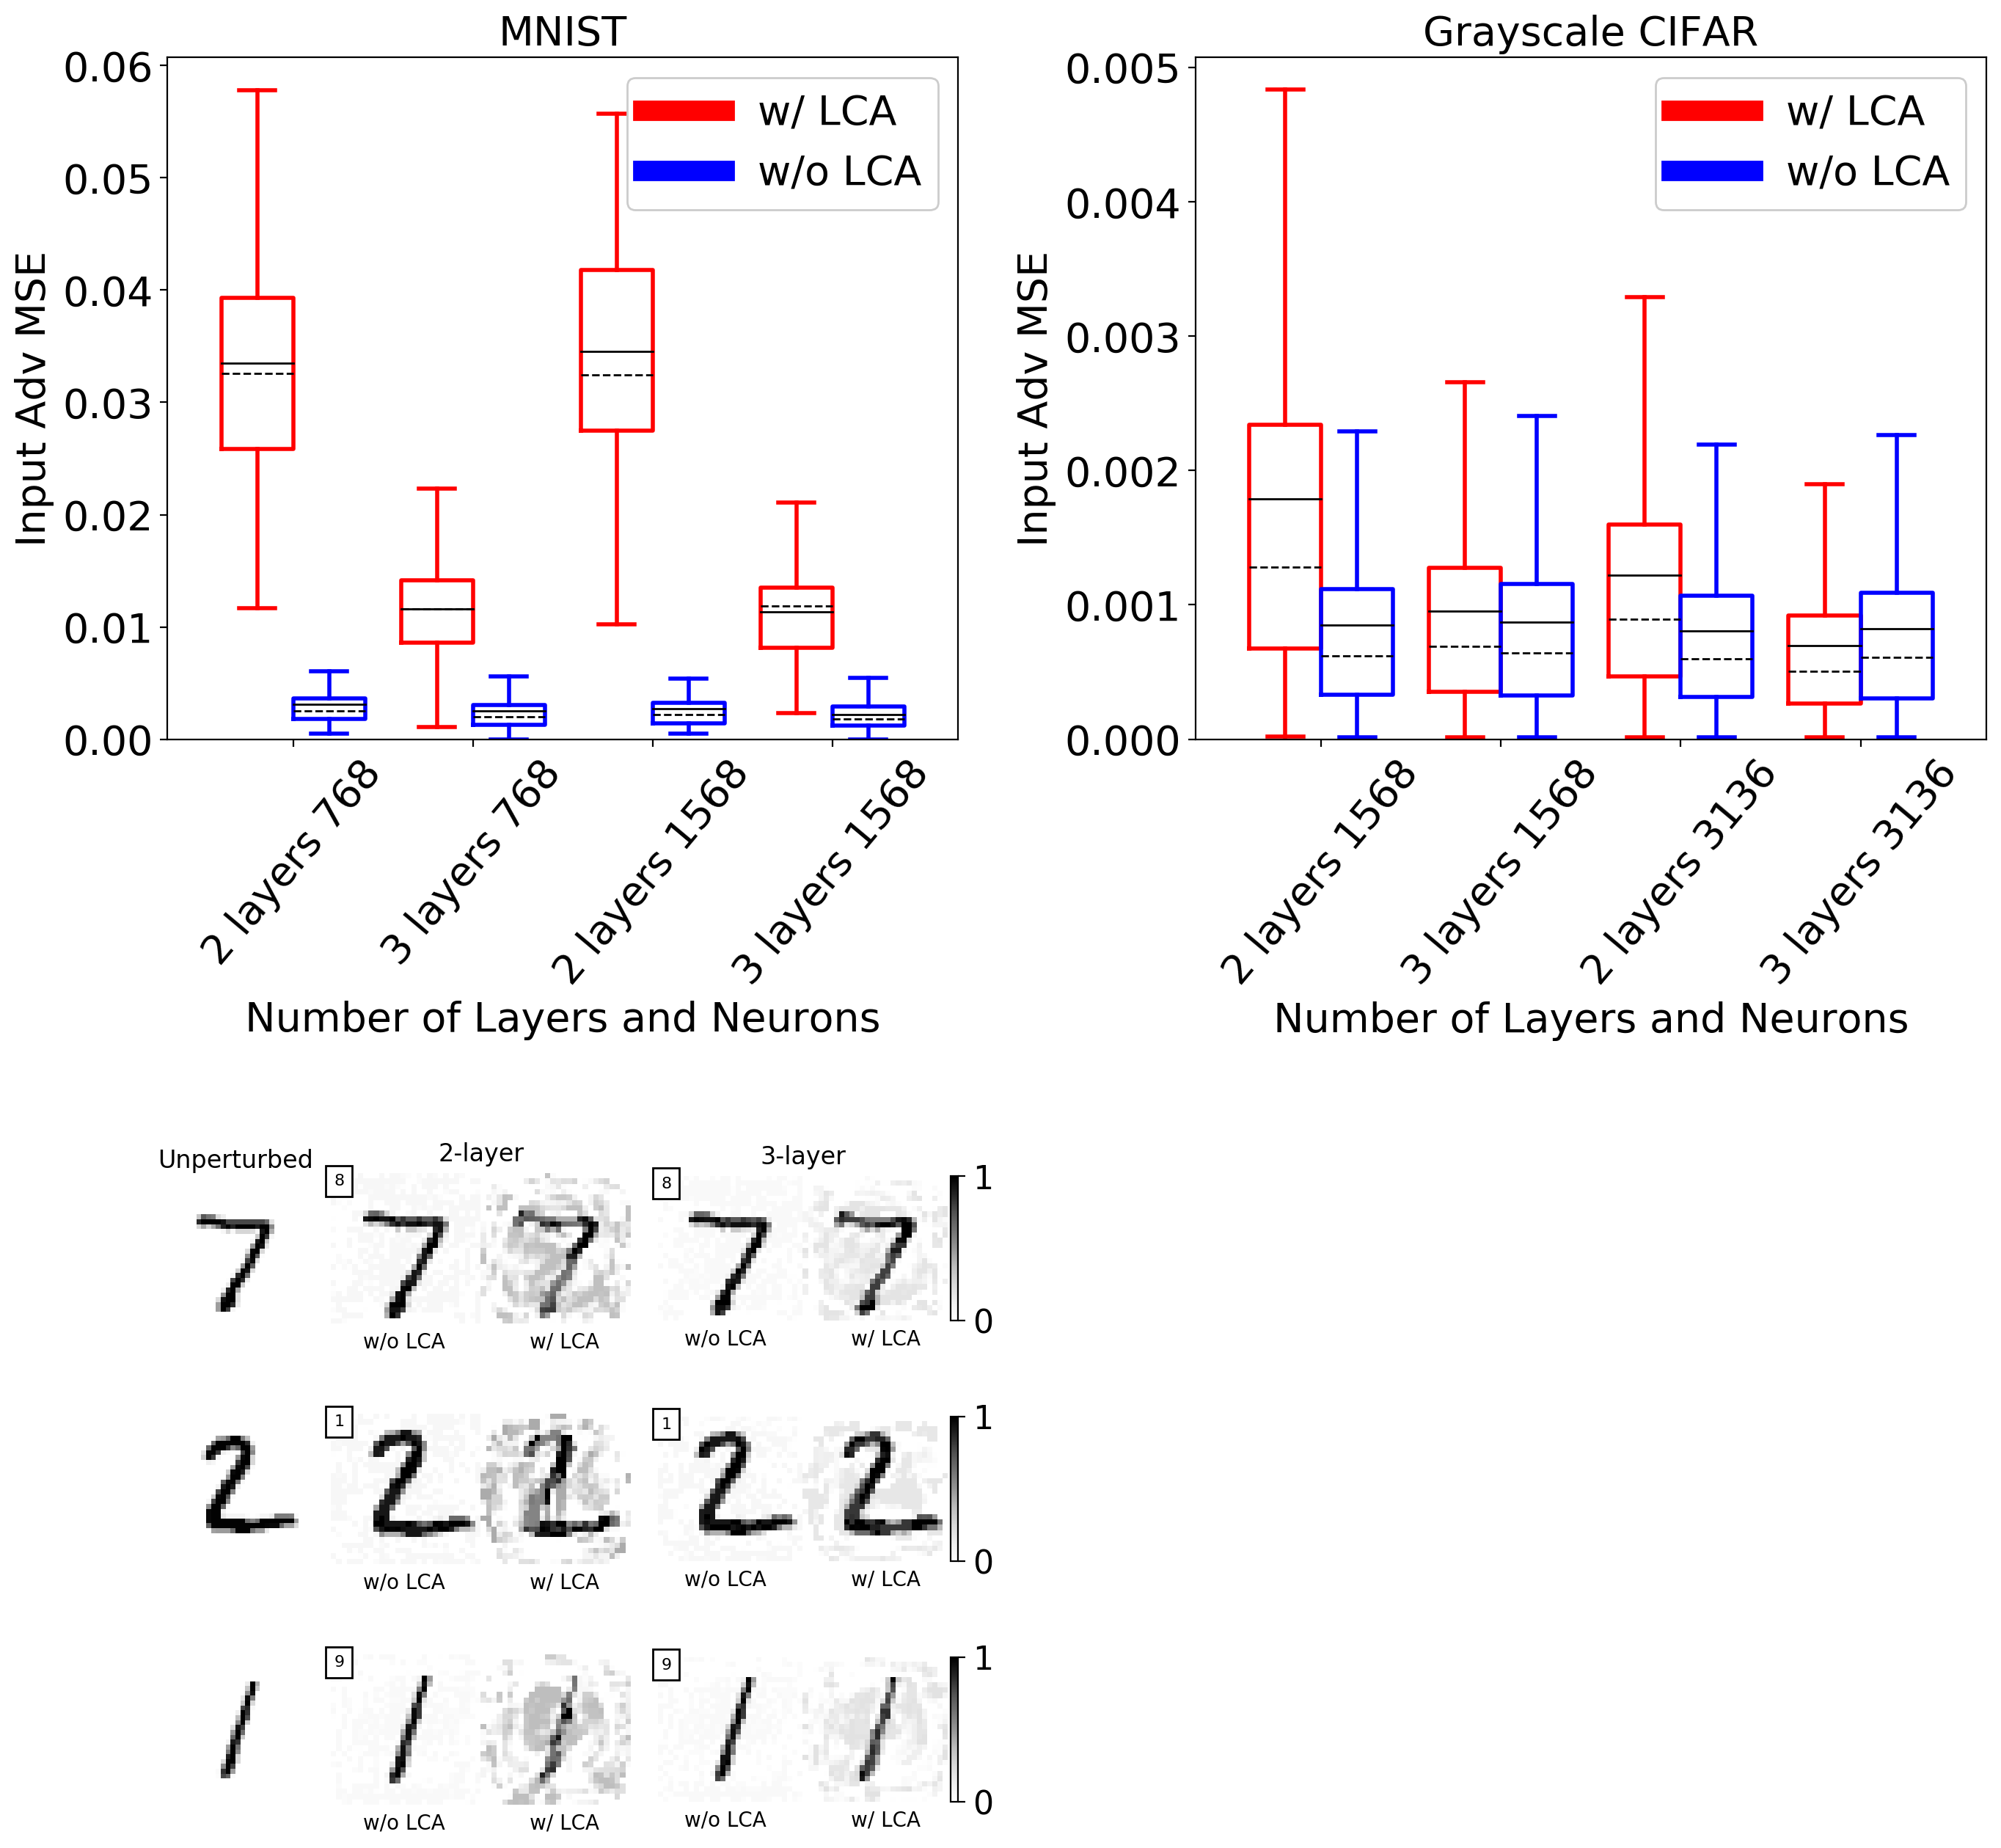

In [54]:
labelrotation = 50
bar_width = 0.4
inner_group_names = ["w/ LCA", "w/o LCA"]
mnist_outer_group_names = ["2 layers 768", "3 layers 768", "2 layers 1568", "3 layers 1568"]
cifar_outer_group_names = ["2 layers 1568", "3 layers 1568", "2 layers 3136", "3 layers 3136"]

COLORS = [
  [1.0, 0.0, 0.0], #"r"
  [0.0, 0.0, 1.0], #"b"
]

#COLORS = ["r", "b"]

#Legend labels:
inner_group_names = ["w/ LCA", "w/o LCA"]
# bar_groups are organized from left to right, with space between inner lists
bar_groups = np.array([[0, 1], [2, 3], [4, 5], [6, 7]])
num_groups = bar_groups.shape[0]
num_per_group = bar_groups.shape[1]

mnist_data, mnist_means, mnist_stds = get_flat_mnist_mse_data(mnist_file_lists, metric, stop_conf)
cifar_data, cifar_means, cifar_stds = get_cifar_mse_data(saved_info, all_cifar_model_names)

fig = plt.figure(figsize=figsize, dpi=dpi)
gs0 = plt.GridSpec(2, 2, figure=fig, hspace=0.6, wspace=0.3)

ax0 = fig.add_subplot(gs0[0,0])
for i_g in range(num_per_group):
  group_data = [mnist_data[i] for i in bar_groups[:, i_g]]
  group_means = [mnist_means[i] for i in bar_groups[:, i_g]]
  group_stds = [mnist_stds[i] for i in bar_groups[:, i_g]]
  x_pos = np.arange(num_groups) + i_g * bar_width
  #ax0 = make_violin(ax0, group_data, group_means, x_pos, bar_width, COLORS[i_g])
  ax0 = make_boxplot(ax0, group_data, group_means, x_pos, bar_width, COLORS[i_g])
legend_elements = [Line2D([0], [0], color=COLORS[0], lw=10),
                   Line2D([0], [0], color=COLORS[1], lw=10)]
ax0.legend(legend_elements, inner_group_names, framealpha=1.0, fontsize=fontsize)
ax0.set_xticks([r + (bar_width)/2 for r in range(num_groups)])
ax0.set_xticklabels(mnist_outer_group_names)
ax0.set_ylabel("Input Adv MSE", fontsize=fontsize)
ax0.set_xlabel('Number of Layers and Neurons', fontsize=fontsize)
ax0.tick_params("both", labelsize=fontsize)
ax0.tick_params("x", labelrotation=labelrotation)
ylim = ax0.get_ylim()
ax0.set_ylim([0, ylim[1]])
ax0.set_title("MNIST", fontsize=fontsize)

ax1 = fig.add_subplot(gs0[0,1])
for i_g in range(num_per_group):
  group_data = [cifar_data[i] for i in bar_groups[:, i_g]]
  group_means = [cifar_means[i] for i in bar_groups[:, i_g]]
  group_stds = [cifar_stds[i] for i in bar_groups[:, i_g]]
  x_pos = np.arange(num_groups) + i_g * bar_width
  #ax1 = make_violin(ax1, group_data, group_means, x_pos, bar_width, COLORS[i_g])
  ax1 = make_boxplot(ax1, group_data, group_means, x_pos, bar_width, COLORS[i_g])
legend_elements = [Line2D([0], [0], color=COLORS[0], lw=10),
                   Line2D([0], [0], color=COLORS[1], lw=10)]
ax1.legend(legend_elements, inner_group_names, framealpha=1.0, fontsize=fontsize)
ax1.set_xticks([r + (bar_width)/2 for r in range(num_groups)])
ax1.set_xticklabels(cifar_outer_group_names)
ax1.set_ylabel("Input Adv MSE", fontsize=fontsize)
ax1.set_xlabel('Number of Layers and Neurons', fontsize=fontsize)
ax1.tick_params("both", labelsize=fontsize)
ax1.tick_params("x", labelrotation=labelrotation)
ylim = ax1.get_ylim()
ax1.set_ylim([0, ylim[1]])
ax1.set_title("Grayscale CIFAR", fontsize=fontsize)

gs_images = gridspec.GridSpecFromSubplotSpec(3, 5, gs0[1,0])#, hspace=-0.6)
ax2 = fig.add_subplot(gs_images[0, 0])
ax3 = fig.add_subplot(gs_images[0, 1:3])
ax4 = fig.add_subplot(gs_images[0, 3:])

ax5 = fig.add_subplot(gs_images[1, 0])
ax6 = fig.add_subplot(gs_images[1, 1:3])
ax7 = fig.add_subplot(gs_images[1, 3:])

ax8 = fig.add_subplot(gs_images[2, 0])
ax9 = fig.add_subplot(gs_images[2, 1:3])
ax10 = fig.add_subplot(gs_images[2, 3:])

image_axes = np.array([[ax2, ax3, ax4], [ax5, ax6, ax7], [ax8, ax9, ax10]])

show_example(image_axes, mlp_img_files, mlp_metric_files, lca_img_files, lca_metric_files,
             stop_conf, ["Unperturbed"]+xtick_labels)

plt.show()

all_model_names = all_mnist_model_names+all_cifar_model_names
project_dir = "/home/dpaiton/Work/Projects/"
out_list = [project_dir + model_name + "/analysis/0.0/vis/adv_mse_comparison" for model_name in all_model_names]
for out_name in out_list:
  for ext in [".png", ".eps"]:
    save_name = out_name+ext
    fig.savefig(save_name, transparent=False, bbox_inches="tight", pad_inches=0.01, dpi=dpi)

# Supplementary Figures/Analysis

### Histogram the MSE datapoints

In [ ]:
lca_data = data_points[2]
n_bins = 25

plt.figure()
hist1, bins = np.histogram(lca_data[0], n_bins)
plt.bar(bins[:n_bins],hist1/len(lca_data[0]), width = .003, alpha=.7, label="lca_2layer")

hist2, bins = np.histogram(lca_data[1], n_bins)
plt.bar(bins[:n_bins],hist2/len(lca_data[1]), width = .003, alpha=.7, label="lca_3layer")

plt.xlabel("Adversarial MSE")
plt.ylabel("Frequency of Images")
plt.legend()

### Average target-class confidence per kurakin attack step

In [ ]:
def plot_average_conf_step(analysis_files, model_names):
    stop_conf=.95 
    fig, ax = plt.subplots()
    for file, name in zip(analysis_files, model_names):
        analysis = np.load(file, allow_pickle=True)["data"].item()
        ax.plot(find_avg_conf_step(analysis), label=name)
    
        print(np.max(find_avg_conf_step(analysis)))
    ax.legend(loc="lower right")
    ax.set_xlabel("Attack Step")
    ax.set_ylabel("Mean Target-class Confidence")
    ax.set_ylim(0,1.1)

In [ ]:
file_path = k_file_path # kurakin
# file_path = c_file_path # carlini
lca_files = [path + model_name + file_path for model_name in [lca_768_2layer]]
mlp_files = [path + model_name + file_path for model_name in [mlp_768_2layer]]
files = mlp_files + lca_files

names = ['w/o LCA', 'w/ LCA'] 
plot_average_conf_step(files, names)

### Average adversarial MSE per kurakin attack step

In [ ]:
def plot_average_mse_step(analysis_files, model_names):
    fig, ax = plt.subplots()

    for file, name in zip(analysis_files, model_names):
        analysis = np.load(file, allow_pickle=True)["data"].item()
        mean_mse, std_mse = find_mse(analysis)
        
        ax.plot(range(len(mean_mse)), mean_mse, label=name, lw=3)
        ax.fill_between(range(len(mean_mse)), mean_mse + std_mse , mean_mse - std_mse, alpha=.3)
        
    ax.legend(loc="upper left")
    ax.set_xlabel("Attack Step")
    ax.set_ylabel("Average Adversarial MSE")

In [ ]:
file_path = k_file_path # kurakin
#file_path = c_file_path # carlini
lca_files = [path + model_name + file_path for model_name in [lca_768_2layer]]
mlp_files = [path + model_name + file_path for model_name in [mlp_768_2layer]]
files = mlp_files + lca_files

names = ['w/o LCA', 'w/ LCA']
plot_average_mse_step(files, names)

## Extra: Differentiable Loss Surface Adversarial Comparison

### File Paths

In [ ]:
mlp = "mlp_cosyne_mnist"
lca = "slp_lca_768_latent_75_steps_mnist"
lista = 'slp_lista_768_5_layers_mnist'
lca_file, lista_file, mlp_file = (path + model_name + k_file_path for model_name in [lca, lista, mlp])
lca_img_file, lista_img_file, mlp_img_file = (path + model_name + k_img_path for model_name in [lca, lista, mlp])

In [ ]:
class params(object):
    def __init__(self, model_name):
        self.model_name = model_name
        self.version = '0.0'
        self.projects_dir = os.path.expanduser("~")+"/Work/Projects/"     
        self.save_info = 'test'
        self.overwrite_analysis_log = False
        self.do_neuron_visualization=False
        
def get_label_est(model_name, input_images):
    # Get params, set dirs
    analysis_params = params(model_name) # construct object

    # Load arguments
    model_name_list = os.listdir(analysis_params.projects_dir)
    analysis_params.model_dir = analysis_params.projects_dir+analysis_params.model_name

    model_log_file = (analysis_params.model_dir+"/logfiles/"+analysis_params.model_name
      +"_v"+analysis_params.version+".log")
    model_logger = Logger(model_log_file, overwrite=False)
    model_log_text = model_logger.load_file()
    model_params = model_logger.read_params(model_log_text)[-1]
    analysis_params.model_type = model_params.model_type

    # Initialize & setup analyzer
    analyzer = ap.get_analyzer(analysis_params.model_type)
    analyzer.setup(analysis_params)
    analysis_params.data_type = analyzer.model_params.data_type
    analyzer.setup_model(analyzer.model_params)
    
    # run forward pass
    with tf.Session(graph=analyzer.model.graph) as sess:
        feed_dict = analyzer.model.get_feed_dict(input_images, is_test=True)
        sess.run(analyzer.model.init_op, feed_dict)
        analyzer.model.load_full_model(sess, analyzer.analysis_params.cp_loc)
        label_est = sess.run(analyzer.model.label_est, feed_dict)
        
    return label_est

### Compare adv. MSE for more differentiable loss surface
 LCA vs LISTA

In [ ]:
xtick_labels = ['MLP', 'LISTA_SLP', 'LCA_SLP']
file_lists = [[mlp_file, lista_file, lca_file]] #, lca_1568_files]

metric = "input_adv_mses"
colors = ['orange']
names = [None]

stop_conf=.95

fig, ax = plt.subplots(1,1)
data_points = adv_mse_comparison_plot(ax, file_lists, metric, stop_conf, colors, names,
                                     xtick_labels, 'Model', 'Mean Squared Distance', .08, width=.5,
                                     fontsize)

### See if LISTA adv. examples translate to LCA

In [ ]:
lista_stop_conf = .95
# get lista adv images
input_images, input_clf, adv_images, adv_clf = get_results([lista_file], [lista_img_file], lista_stop_conf)
# pass through the models
lca_softmax_labels = get_label_est(lca, adv_images[0])
lista_softmax_labels = get_label_est(lista, adv_images[0])
mlp_softmax_labels = get_label_est(mlp, adv_images[0])

In [ ]:
# organize the data
lca_confs_lista_adv = [out[cls] for out, cls in zip(lca_softmax_labels, adv_clf[0])]
lca_confs_input = [out[cls] for out, cls in zip(lca_softmax_labels, input_clf[0])]

mlp_confs_lista_adv = [out[cls] for out, cls in zip(mlp_softmax_labels, adv_clf[0])]
mlp_confs_input = [out[cls] for out, cls in zip(mlp_softmax_labels, input_clf[0])]

lista_confs_lista_adv = [out[cls] for out, cls in zip(lista_softmax_labels, adv_clf[0])]
lista_confs_input = [out[cls] for out, cls in zip(lista_softmax_labels, input_clf[0])]

filter_indices = np.where(np.array(lista_confs_lista_adv) > .8)[0]

data = [[lista_confs_input, lista_confs_lista_adv],
        [mlp_confs_input, mlp_confs_lista_adv],
        [lca_confs_input, lca_confs_lista_adv]]

data = [[np.array(confs)[filter_indices] for confs in model_confs] for model_confs in data]
means = [[np.mean(confs) for confs in model_confs] for model_confs in data]
stds = [np.array([[0,0],[np.std(confs) for confs in model_confs]]) for model_confs in data]

In [ ]:
colors = ['blue', 'green', 'orange']
xtick_labels = ["Original Label", "Adv Target Label"]
xlabel = None#"Class Position"
ylabel = "Softmax Confidence"
names = ['LISTA_SLP', 'MLP', 'LCA_SLP']

fig, ax = plt.subplots(1,1)
multi_model_compare(ax, data, means, stds, colors, names, xtick_labels, xlabel, ylabel, 1, width=.25);

### Extreme examples 
Find the LISTA adv. examples that produce a strong confidence in the adv target label

In [ ]:
def show_extremes(images, clfs, n_extreme, confs, model_names):
    assert len(model_names) == len(confs)
    
    fig, ax = plt.subplots(len(confs), n_extreme, figsize=(10,5))
    
    for i, name in enumerate(model_names): 
        conf = confs[i]
        extreme_ind = np.argsort(conf)[-n_extreme:]
        extreme_images = images[extreme_ind]
        extreme_clfs = clfs[extreme_ind]
        extreme_confs = np.round(np.sort(conf)[-n_extreme:], 2)

        for j in range(n_extreme):
            if j == 0:
                ax[i,j].set_ylabel(name, rotation="vertical")
                
            show(ax[i, j], extreme_images[n_extreme-1-j].reshape(28,28), extreme_clfs[n_extreme-1-j]) 
            ax[i,j].set_xlabel("conf = "+ str(extreme_confs[n_extreme-1-j]))
    fig.suptitle("Most Transferable LISTA Examples")
    fig.tight_layout()

In [ ]:
# Find top 5 most- translatable adv examples
n_extreme = 5
# LCA
show_extremes(adv_images[0][filter_indices], adv_clf[0][filter_indices], n_extreme,
             [np.array(lca_confs_lista_adv)[filter_indices], np.array(mlp_confs_lista_adv)[filter_indices]],
             ["w/ LCA", "w/o LCA"])